# Table of Contents

* [Macro Economic](#chapter1)

* [Temperature](#chapter2)

* [Power Consumption & Production](#chapter3)

* [Temperature Trends](#chapter4)

* [Macro Trends](#chapter5)

* [Trend Evaluation - Temperature](#chapter6)
    * [Further Evaluation](#section_6_1)
    * [Manipulating datetime indexes](#section_6_2)
    
* [Decomposition - Temperature](#chapter7)
    * [Decomposition model class](#section_7_1)
    * [Linear trend component](#section_7_2)
    * [Monthly trend component](#section_7_3)
    * [Hourly trend component](#section_7_4)
    * [Data Pipelines](#section_7_5)
    * [Output Analysis](#section_7_6)
    * [Generate Predictions](#section_7_7)

* [Decomposition - Power](#chapter8)

* [Synthetic AR Models](#chapter9)
    * [AR(1) Model](#section_9_1)
    * [AR(2) Model](#section_9_2)
    
* [Foreasting - Power](#chapter10)

* [Prediction - Power](#chapter11)
    * [Use prior measures on the forecasts](#section_11_1)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
import math
from sklearn.linear_model import LinearRegression
import pickle
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [2]:
data_path = os.path.join(os.path.abspath('.'), 'data', 'time_series')

import sys
sys.path.append(os.path.join(os.path.abspath('.'), 'data'))
import time_series_functions.regression as rgs
import time_series_functions.metrics as metrics

# 1. Macro Economic<a class="anchor" id="chapter1"></a>

In [3]:
region = "England"
rent_path = os.path.join(data_path, 'rents', 'rents.csv')
rent_df = pd.read_csv(rent_path)


rent_rate_path = os.path.join(data_path, 'rents', 'rent-increases.csv')
rent_rate_df = pd.read_csv(rent_rate_path)

def clean_df(df):
    
    cols = {
        rent_rate_df.columns[0] : 'year', 
        rent_rate_df.columns[1] : 'month'
    }
    df = df.rename(columns = cols)
    df = df[['year','month','England']]
    df = df.iloc[: -4 , :]
    df['year'].ffill(inplace=True)
    df['date'] = pd.DatetimeIndex(
        data=df['year'] + ' ' + df['month']
    )
    df['date'] = pd.to_datetime(df['date'], format = "%Y %b")
    df = df.set_index('date')
    #df = df.asfreq('M') 
    # this changes stuff but if we can incorporate this it would be good 
    
    return df

rent_df = clean_df(rent_df)
rent_df.columns = ['year','month','rent_level']
rent_rate_df = clean_df(rent_rate_df)
rent_rate_df.columns = ['year','month','rent_rate']

display(rent_df)

,year,month,rent_level
date,,,
2005-01-01,2005,Jan,81.5
2005-02-01,2005,Feb,81.6
2005-03-01,2005,Mar,81.7
2005-04-01,2005,Apr,81.8
2005-05-01,2005,May,82.0
2005-06-01,2005,Jun,82.1
2005-07-01,2005,Jul,82.3
2005-08-01,2005,Aug,82.5
2005-09-01,2005,Sep,82.7


In [10]:
income_path = os.path.join(data_path, 'rents', 'income.csv')
income_df = pd.read_csv(income_path)

income_df['date'] = pd.to_datetime(income_df['date'], format = "%Y %b")
income_df = income_df.set_index('date')
income_df.columns = ['income_rate']

display(income_df)

,income_rate
date,
2001-03-01,6.2
2001-04-01,6.3
2001-05-01,5.1
2001-06-01,5.5
2001-07-01,5.2
2001-08-01,5.2
2001-09-01,4.8
2001-10-01,4.7
2001-11-01,4.5


In [11]:
income_df['income_level'] = 100

for i, d in enumerate(income_df.index):
    if i == 0:
        continue
        
    rate = income_df['income_rate'].iloc[i]
    previous = income_df['income_level'].iloc[i-1]
    
    current = previous * ( 1 + rate / (12 * 100))
    
    income_df.loc[d, 'income_level'] = current
    
display(income_df.head())

,income_rate,income_level
date,,
2001-03-01,6.2,100.000000
2001-04-01,6.3,100.525000
2001-05-01,5.1,100.952231
2001-06-01,5.5,101.414929
2001-07-01,5.2,101.854394


In [14]:
rents = pd.merge(rent_rate_df, rent_df, how='inner', on='date')
total = pd.merge(rents, income_df, how = 'left', on='date')
total = total.drop(total.columns[[0,1,3,4]], axis=1)
total

,rent_rate,rent_level,income_rate,income_level
date,,,,
2006-01-01,2.5,83.5,4.4,121.378681
2006-02-01,2.5,83.7,4.9,121.874310
2006-03-01,2.6,83.8,5.2,122.402432
2006-04-01,2.6,84.0,5.4,122.953243
2006-05-01,2.6,84.1,4.9,123.455302
2006-06-01,2.6,84.2,4.9,123.959412
2006-07-01,2.6,84.4,4.8,124.455249
2006-08-01,2.5,84.6,4.6,124.932328
2006-09-01,2.4,84.7,3.9,125.338358


In [15]:
# level rebasement

total['new_rent_level'] = (
    100 / total['rent_level'].iloc[0]
) * total['rent_level']

total['new_income_level'] = (
    100 / total['income_level'].iloc[0]
) * total['income_level']

total

,rent_rate,rent_level,income_rate,income_level,new_rent_level,new_income_level
date,,,,,,
2006-01-01,2.5,83.5,4.4,121.378681,100.000000,100.000000
2006-02-01,2.5,83.7,4.9,121.874310,100.239521,100.408333
2006-03-01,2.6,83.8,5.2,122.402432,100.359281,100.843436
2006-04-01,2.6,84.0,5.4,122.953243,100.598802,101.297232
2006-05-01,2.6,84.1,4.9,123.455302,100.718563,101.710862
2006-06-01,2.6,84.2,4.9,123.959412,100.838323,102.126181
2006-07-01,2.6,84.4,4.8,124.455249,101.077844,102.534686
2006-08-01,2.5,84.6,4.6,124.932328,101.317365,102.927736
2006-09-01,2.4,84.7,3.9,125.338358,101.437126,103.262251


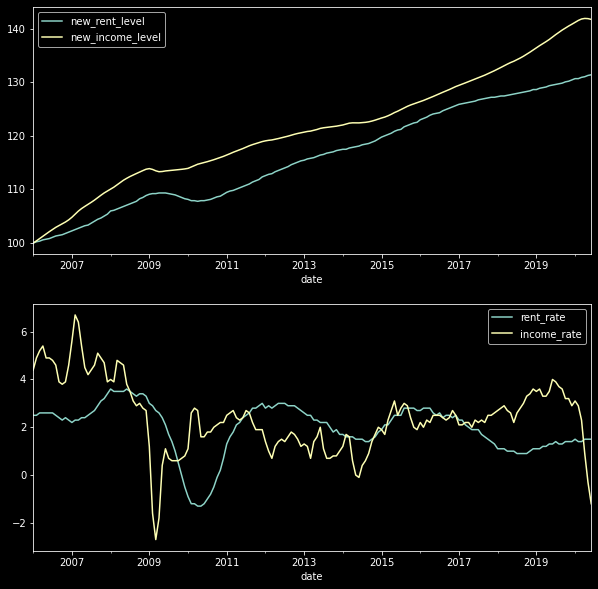

In [16]:
# visualise

fig, ax = plt.subplots(2, 1,figsize=(10,10))
total[['new_rent_level','new_income_level']].plot(ax = ax[0])
total[['rent_rate','income_rate']].plot(ax = ax[1])
fig.savefig(os.path.join(data_path, 'rents', 'income_and_rent.png'))

# 2. Temperature<a class="anchor" id="chapter2"></a>

In [17]:
input_filename = os.path.join(
    data_path, 'weather', 'jena_climate_2009_2016.csv'
)
output_filename = os.path.join(
    data_path, 'weather', 'temperature.pickle'
)

rent_rate_path 

df = pd.read_csv(input_filename)
df = df[['T (degC)', 'Date Time']]

df['Date Time'] = pd.to_datetime(
    df['Date Time'], format = '%d.%m.%Y %H:%M:%S'
)
df = df.rename(columns={'T (degC)' : 'temp', 'Date Time': 'date'})
df = df.set_index('date')
df.head()

,temp
date,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27


In [18]:
# data cleaning: NULL's and duplicates

print('Dataframe shape:', df.shape) # pre duplicates
dupes = df.index.duplicated()
df = df[dupes == False]
df
print('Dataframe shape (duplicates dropped):', df.shape) # post duplicates
df = df.asfreq('10T') # this adds 544 rows for temperature
print('Dataframe shape (recast at 10T frequency):', df.shape)
num_na = df.isna().sum()
print()
print('Number of missing temperatures:', num_na)
df = df.interpolate() # not ideal
num_na = df.isna().sum()
print('Number of missing temperatures:', num_na)

Dataframe shape: (420551, 1)
Dataframe shape (duplicates dropped): (420224, 1)
Dataframe shape (recast at 10T frequency): (420768, 1)

Number of missing temperatures: temp    544
dtype: int64
Number of missing temperatures: temp    0
dtype: int64


In [19]:
# save cleaner data

df.to_pickle(output_filename)

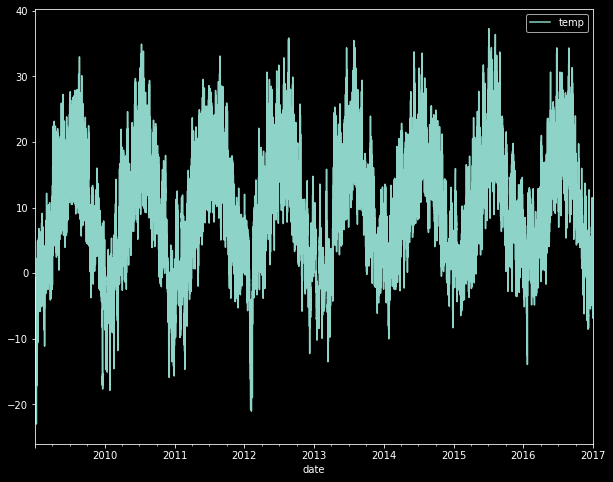

In [20]:
# clear seasonality

df.plot(figsize=(10, 8));

In [21]:
# resample

daily_df = df[['temp']].resample('D').mean() # resample to average daily
daily_df['max'] = df[['temp']].resample('D').max() # max daily
daily_df['min'] = df[['temp']].resample('D').min() # min daily
daily_df['range'] = daily_df['max'] - daily_df['min'] # daily range

weekly_df = df[['temp']].resample('W').mean() # weekly mean

<AxesSubplot:xlabel='date'>

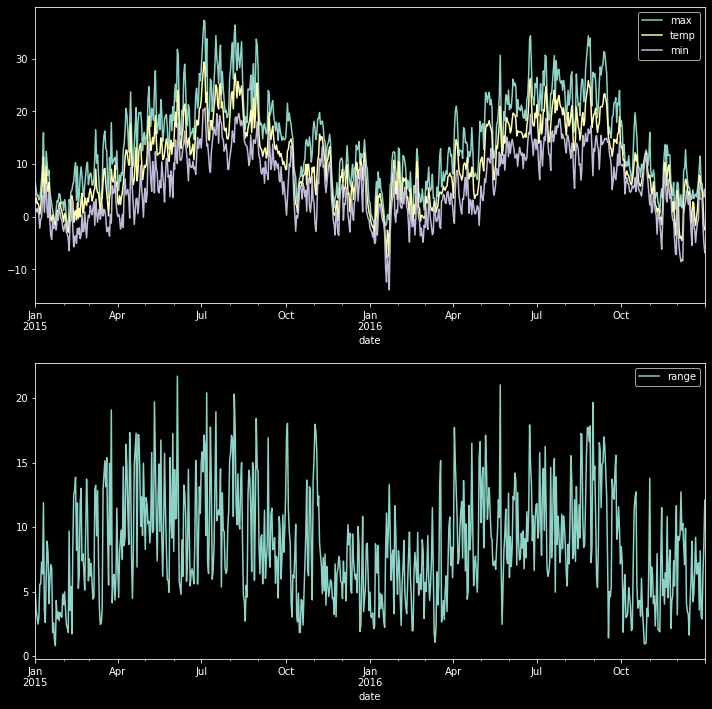

In [22]:
# plot

fig, ax = plt.subplots(2,1,figsize=(12,12))

daily_df.loc['2015':'2016',['max','temp','min']].plot(ax=ax[0])
daily_df.loc['2015':'2016',['range']].plot(ax=ax[1])

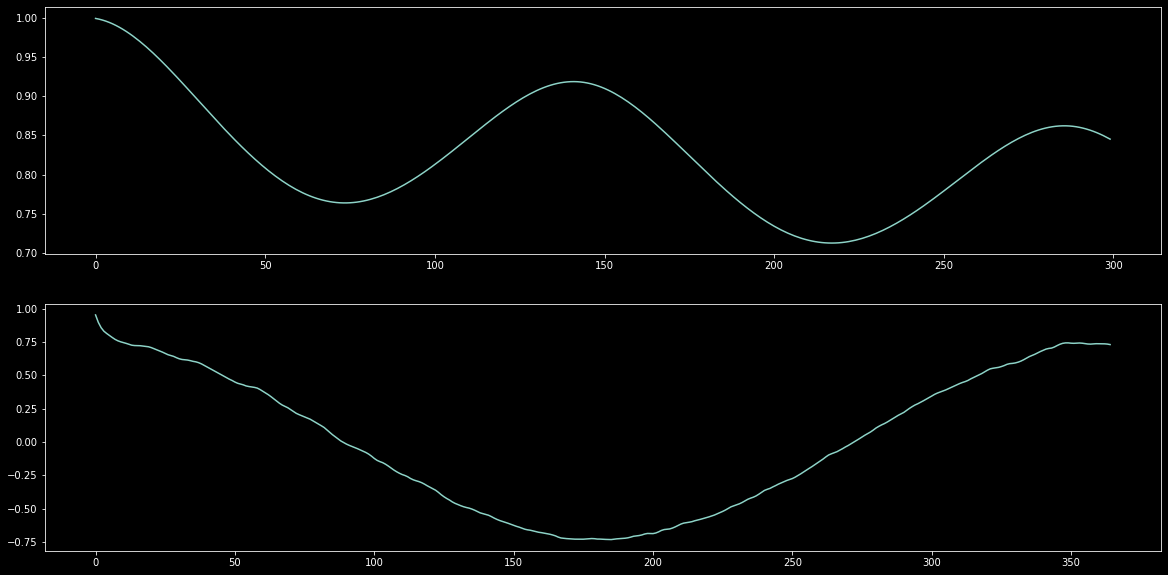

In [23]:
# autocorrelation

def acf(x, lags):
    return [x.autocorr(lag) for lag in range(1, lags+1)]

temp_acf = acf(df['temp'],300)

temp_daily_acf = acf(daily_df['temp'], 365)

fig, ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(temp_acf)
ax[1].plot(temp_daily_acf);

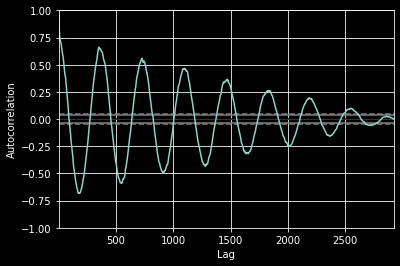

In [24]:
pd.plotting.autocorrelation_plot(daily_df['temp']);

<AxesSubplot:xlabel='month', ylabel='temp'>

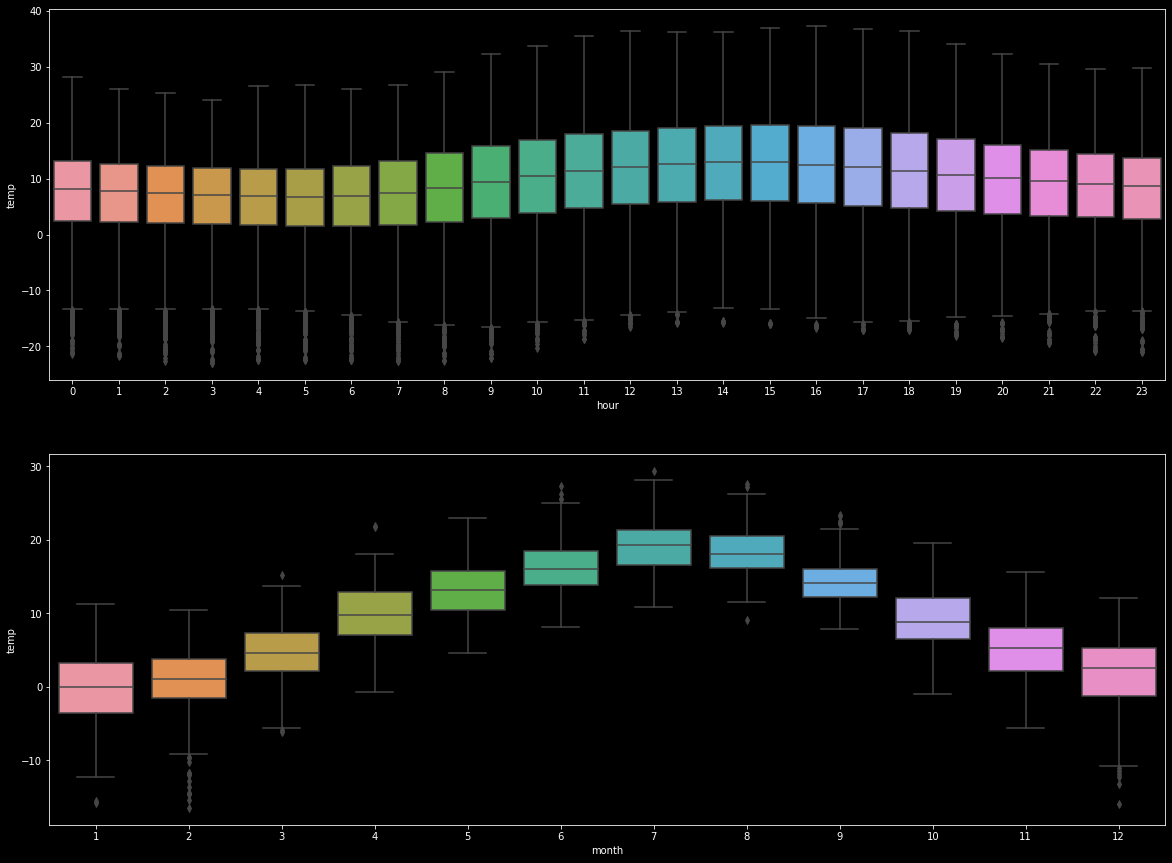

In [25]:
# boxplots

daily_df['month'] = daily_df.index.month
df['hour'] = df.index.hour

fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.boxplot(data=df, x = 'hour', y = 'temp', ax=ax[0])
sns.boxplot(data=daily_df, x = 'month', y = 'temp', ax=ax[1])

# 3. Power Consumption & Production<a class="anchor" id="chapter3"></a>

In [26]:
input_filepath = os.path.join(
    data_path, 'power', 'german_daily_power.csv'
)
output_filename = os.path.join(
    data_path, 'power', 'german_daily_power.pickle'
)

df = pd.read_csv(input_filepath)
display(df.sample(10))

,Date,Consumption,Wind,Solar,Wind+Solar
2244,2012-02-23,1427.40200,353.510,18.927,372.437
411,2007-02-16,1485.30700,NaN,NaN,NaN
1990,2011-06-14,1363.21300,32.813,NaN,NaN
1639,2010-06-28,1327.92200,19.296,NaN,NaN
4282,2017-09-22,1401.40633,16.478,113.891,130.369
3929,2016-10-04,1422.06600,363.248,77.268,440.516
2809,2013-09-10,1346.69600,131.483,53.687,185.170
2785,2013-08-17,1064.70400,50.787,150.753,201.540
2919,2013-12-29,1031.14900,213.978,20.933,234.911
3706,2016-02-24,1578.57300,251.744,74.177,325.921


In [27]:
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df = df.set_index('Date')
df = df.asfreq('D') # asfreq datafranme
display(df.head(10))
print(f'Shape: {df.shape}')

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN
2006-01-06,1403.427,NaN,NaN,NaN
2006-01-07,1300.287,NaN,NaN,NaN
2006-01-08,1207.985,NaN,NaN,NaN
2006-01-09,1529.323,NaN,NaN,NaN


Shape: (4383, 4)


In [28]:
dupes = df.index.duplicated()
df = df[dupes == False]
print(f'Shape: {df.shape}')

Shape: (4383, 4)


In [29]:
# consumption NULLs

df[df['Consumption'].isnull()]

,Consumption,Wind,Solar,Wind+Solar
Date,,,,


In [30]:
# wind NULLs

wind_df = df[df.index > pd.to_datetime('2010-01-01', format = '%Y-%m-%d')]
wind_df[wind_df['Wind'].isnull()]

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2011-12-14,1531.311,NaN,NaN,NaN
2014-03-12,1516.331,NaN,148.507,NaN


In [31]:
# solar NULLs

solar_df = df[df.index > pd.to_datetime('2012-01-01', format = '%Y-%m-%d')]
solar_df[solar_df['Solar'].isnull()]

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2013-03-30,1092.932,20.545,NaN,NaN
2013-03-31,1002.856,39.624,NaN,NaN
2014-03-29,1243.377,68.398,NaN,NaN
2014-03-30,1125.085,18.572,NaN,NaN


In [32]:
# interpolate 

wind_df['Wind'].fillna(wind_df['Wind'].interpolate())
solar_df['Solar'].fillna(solar_df['Solar'].interpolate())

Date
2012-01-02     6.574
2012-01-03    24.679
2012-01-04    14.681
2012-01-05     5.071
2012-01-06    13.160
               ...  
2017-12-27    16.530
2017-12-28    14.162
2017-12-29    29.854
2017-12-30     7.467
2017-12-31    19.980
Freq: D, Name: Solar, Length: 2191, dtype: float64

In [33]:
# rejoin

df = df.drop(df.columns[[1,2,3]], axis=1)
df = pd.merge(df, wind_df['Wind'], how='left', left_index=True, right_index=True)
df = pd.merge(df, solar_df['Solar'], how='left', left_index=True, right_index=True)
df['Wind + Solar'] = df['Wind'] + df['Solar']
df

,Consumption,Wind,Solar,Wind + Solar
Date,,,,
2006-01-01,1069.18400,NaN,NaN,NaN
2006-01-02,1380.52100,NaN,NaN,NaN
2006-01-03,1442.53300,NaN,NaN,NaN
2006-01-04,1457.21700,NaN,NaN,NaN
2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


In [34]:
# add year, month, weekday name 

df['month'] = df.index.month
df['year'] = df.index.year

weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['weekday'] = df.index.weekday.map(weekdays)
df

,Consumption,Wind,Solar,Wind + Solar,month,year,weekday
Date,,,,,,,
2006-01-01,1069.18400,NaN,NaN,NaN,1,2006,Sunday
2006-01-02,1380.52100,NaN,NaN,NaN,1,2006,Monday
2006-01-03,1442.53300,NaN,NaN,NaN,1,2006,Tuesday
2006-01-04,1457.21700,NaN,NaN,NaN,1,2006,Wednesday
2006-01-05,1477.13100,NaN,NaN,NaN,1,2006,Thursday
...,...,...,...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037,12,2017,Wednesday
2017-12-28,1299.86398,506.424,14.162,520.586,12,2017,Thursday
2017-12-29,1295.08753,584.277,29.854,614.131,12,2017,Friday


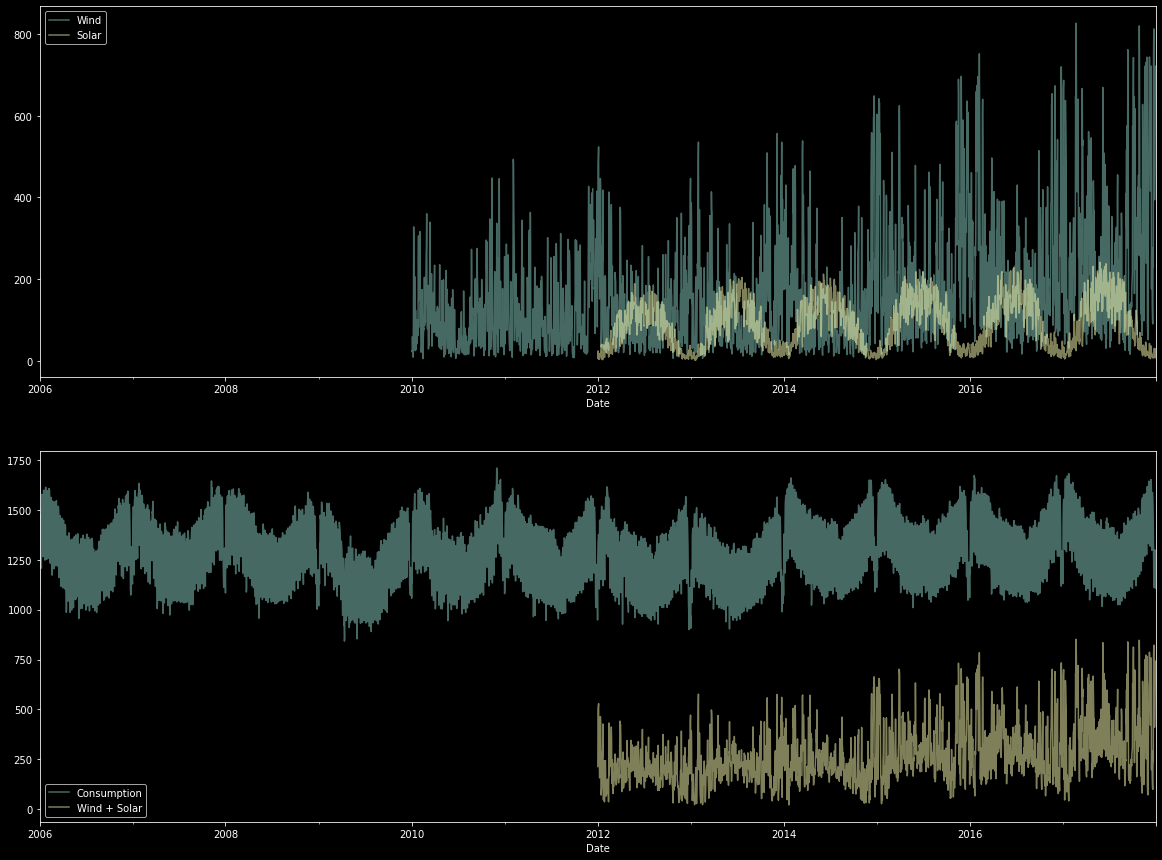

In [35]:
# plot

fig, ax = plt.subplots(2,1,figsize=(20,15))
df[['Wind','Solar']].plot(ax=ax[0], alpha = 0.5)
df[['Consumption','Wind + Solar']].plot(ax=ax[1], alpha = 0.5);

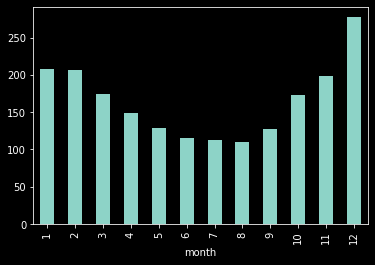

In [36]:
# monthly wind

df[['month','Wind']].groupby('month')['Wind'].mean().plot.bar();

<AxesSubplot:xlabel='year'>

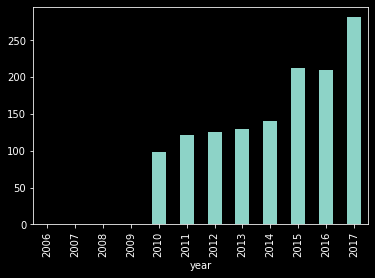

In [37]:
# yearly wind

df[['year','Wind']].groupby('year')['Wind'].mean().plot.bar()

<AxesSubplot:xlabel='weekday'>

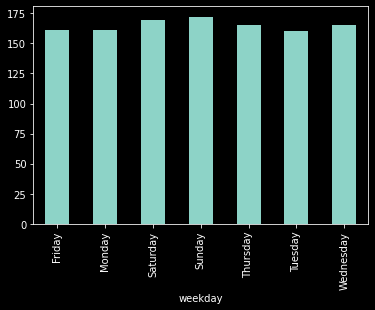

In [38]:
# weekday wind

df[['weekday','Wind']].groupby('weekday')['Wind'].mean().plot.bar()

In [39]:
# save

df.to_pickle(output_filename)

# 4. Temperature Trends<a class="anchor" id="chapter4"></a>

In [40]:
input_filename = os.path.join(
    data_path, 'weather', 'temperature.pickle'
)

df = pd.read_pickle(input_filename)
isna = df.isna()
print(f'10T data: there are {(isna.sum().sum())} missing values.')

df.index

10T data: there are 0 missing values.


DatetimeIndex(['2009-01-01 00:10:00', '2009-01-01 00:20:00',
               '2009-01-01 00:30:00', '2009-01-01 00:40:00',
               '2009-01-01 00:50:00', '2009-01-01 01:00:00',
               '2009-01-01 01:10:00', '2009-01-01 01:20:00',
               '2009-01-01 01:30:00', '2009-01-01 01:40:00',
               ...
               '2016-12-31 22:30:00', '2016-12-31 22:40:00',
               '2016-12-31 22:50:00', '2016-12-31 23:00:00',
               '2016-12-31 23:10:00', '2016-12-31 23:20:00',
               '2016-12-31 23:30:00', '2016-12-31 23:40:00',
               '2016-12-31 23:50:00', '2017-01-01 00:00:00'],
              dtype='datetime64[ns]', name='date', length=420768, freq='10T')

<AxesSubplot:xlabel='date'>

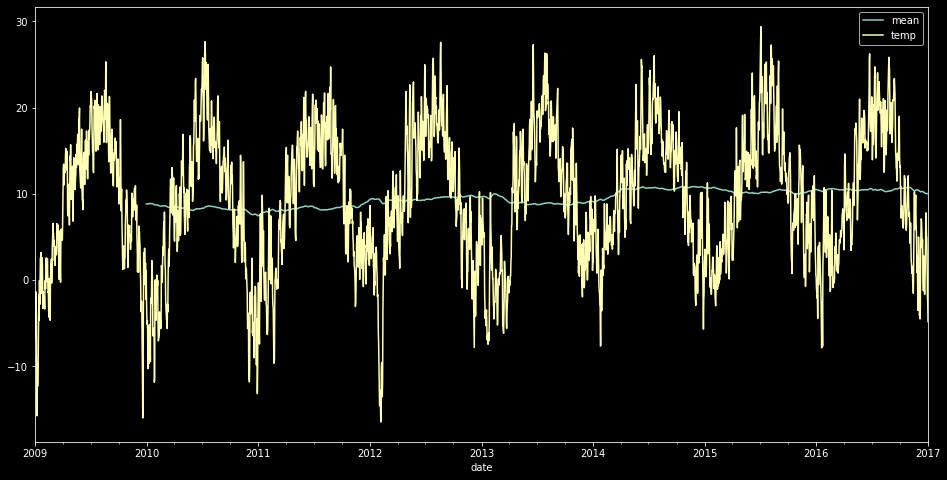

In [41]:
# get rolling mean (yearly) temperature

daily_df = df.resample('D').mean()
daily_df['mean'] = daily_df['temp'].rolling(365).mean()
daily_df[['mean', 'temp']].plot(figsize=(16,8))

	there are (2559, 1) points


<AxesSubplot:xlabel='date'>

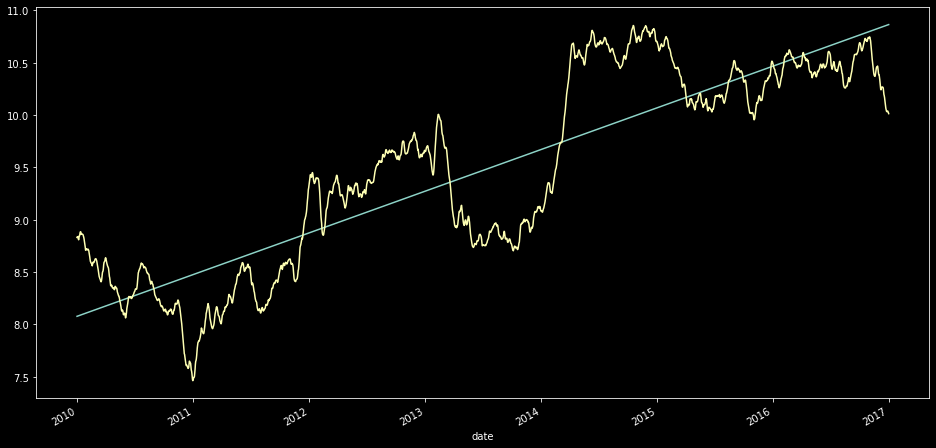

In [42]:
# form a y-series out of that rolling mean 

y_series = daily_df['mean']
y_series = y_series.dropna()

# form an x series 
x_series = pd.Series(range(len(y_series)))
x_series[0:5]

(m, c, r_squared) = rgs.get_linear_fit(x_series, y_series)

x_points = [0, x_series.iloc[-1]]
y_points = [m * x + c for x in x_points]
date_points = [
    y_series.index[0], 
    y_series.index[-1]
]

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(date_points, y_points)
daily_df['mean'].plot(ax=ax)

In [43]:
# rolling window - linear trend fit & prediction

def predict_from_trend(training_df, test_df_index, col='mean'):
    
    y_series = training_df[col]
    y_series = y_series.dropna()

    x_series = pd.Series(range(len(y_series)))
    
    (m,c,r_squared) = rgs.get_linear_fit(x_series, y_series)
    
    x_points = [0, x_series.iloc[-1]]
    y_points = [m*x+c for x in x_points]
    date_points = [y_series.index[0], y_series.index[-1]]
    
    line = (date_points, y_points)
    pred_df = pd.DataFrame(index = test_df_index)
    date_zero = date_points[0]
    pred_df['naive'] = y_series.iloc[-1]    
    pred_df['pred'] = pred_df.apply(
        lambda row : m * ((row.name - date_zero).days) + c, axis=1
    )
    return pred_df, line

	there are (1096, 1) points
	there are (1096, 1) points
	there are (1096, 1) points


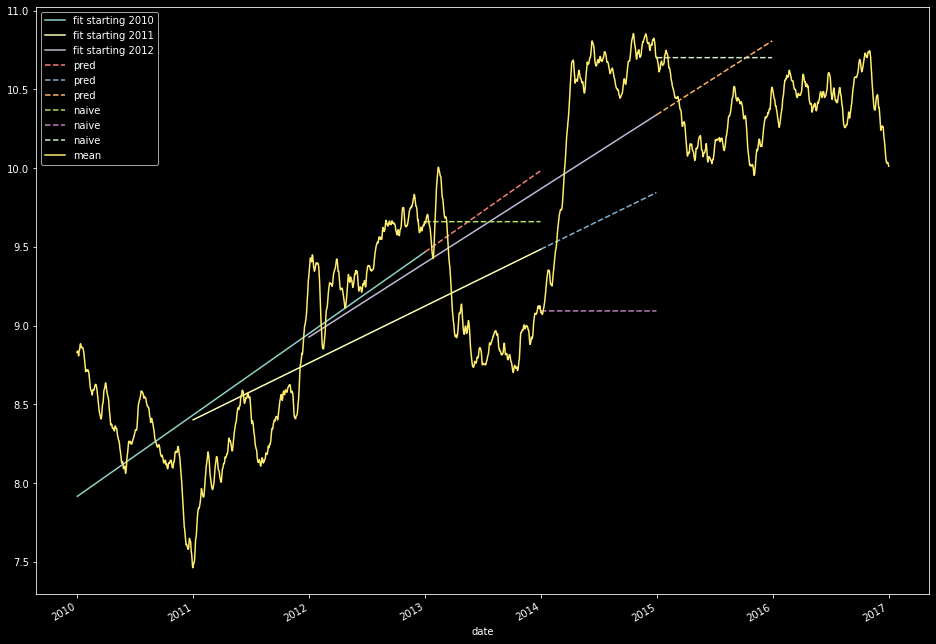

In [44]:
start_years = [2010, 2011, 2012]
fitted_lines = []
final_df = daily_df.copy()
n = 3

fig ,ax = plt.subplots(figsize=(16, 12))

for start_year in start_years:
    
    training_df = daily_df.loc[
        str(start_year): str(start_year + 2), :
    ]
    test_df = daily_df.loc[str(start_year + 3), :]
    
    pred_df, line = predict_from_trend(training_df, test_df.index)
    final_df = pd.concat([final_df, pred_df], axis=1)
    
    fitted_lines.append(line)

for year, line in  zip(start_years, fitted_lines):
    
    ax.plot(line[0], line[1], label='fit starting ' + str(year))
    
final_df[['pred']].plot(ax=ax, linestyle='--')
final_df[['naive']].plot(ax=ax, linestyle='--')
final_df[['mean']].plot(ax=ax)
ax.legend();

# obvs these predictions are not very good

# 5. Macro Trends<a class="anchor" id="chapter5"></a>

In [45]:
input_filename = os.path.join(
    data_path, 'rents', 'income_and_rent.pickle'
)

df = pd.read_pickle(input_filename)
df.head()

,rent_rate,rent_level,income_rate,income_level,new_rent_level,new_income_level
date,,,,,,
2006-01-01,2.5,83.5,4.4,121.378681,100.000000,100.000000
2006-02-01,2.5,83.7,4.9,121.874310,100.239521,100.408333
2006-03-01,2.6,83.8,5.2,122.402432,100.359281,100.843436
2006-04-01,2.6,84.0,5.4,122.953243,100.598802,101.297232
2006-05-01,2.6,84.1,4.9,123.455302,100.718563,101.710862


In [46]:
y_series = df['new_income_level']
y_series = y_series.dropna()

y2_series = df['new_rent_level']
y2_series = y2_series.dropna()

x_series = pd.Series(range(len(y_series)))
x2_series = pd.Series(range(len(y2_series)))

(m,c,r_squared) = rgs.get_linear_fit(x_series, y_series)
x_points = [0, x_series.iloc[-1]]
y_points = [m*x + c for x in x_points]

date_points = [y_series.index[0], y_series.index[-1]]

(m,c,r_squared) = rgs.get_linear_fit(x2_series, y2_series)
x2_points = [0, x2_series.iloc[-1]]
y2_points = [m*x + c for x in x2_points]

date2_points = [y2_series.index[0], y2_series.index[-1]]

	there are (174, 1) points
	there are (174, 1) points


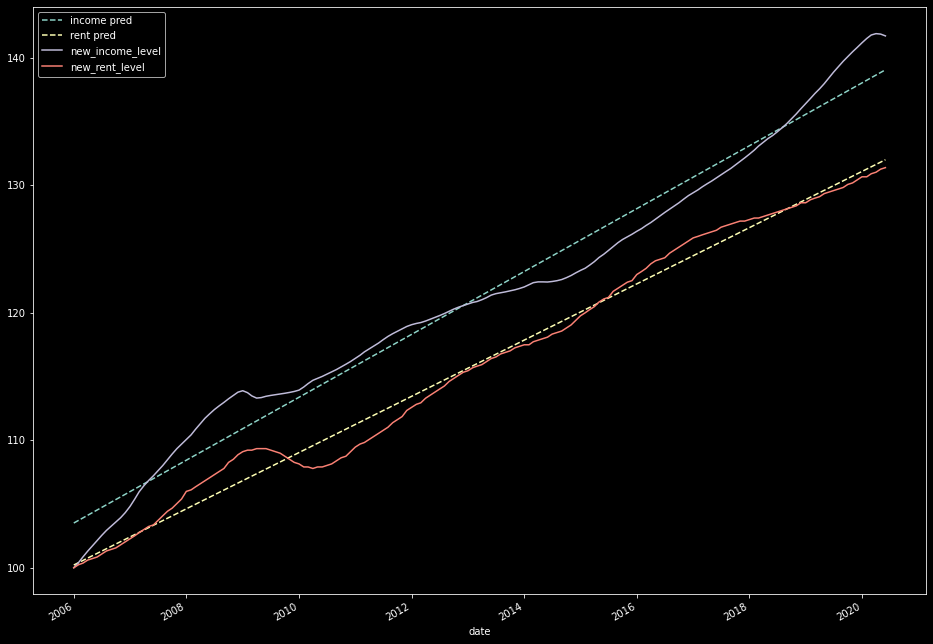

In [47]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(date_points, y_points, linestyle='--', label='income pred')
ax.plot(date2_points, y2_points, linestyle='--', label='rent pred')
df['new_income_level'].plot(ax=ax)
df['new_rent_level'].plot(ax=ax)
ax.legend()
plt.show()

	there are (36, 1) points
	there are (36, 1) points
	there are (36, 1) points
	there are (36, 1) points
	there are (36, 1) points
	there are (36, 1) points
	there are (36, 1) points
	there are (36, 1) points
	there are (36, 1) points
	there are (36, 1) points
	there are (36, 1) points


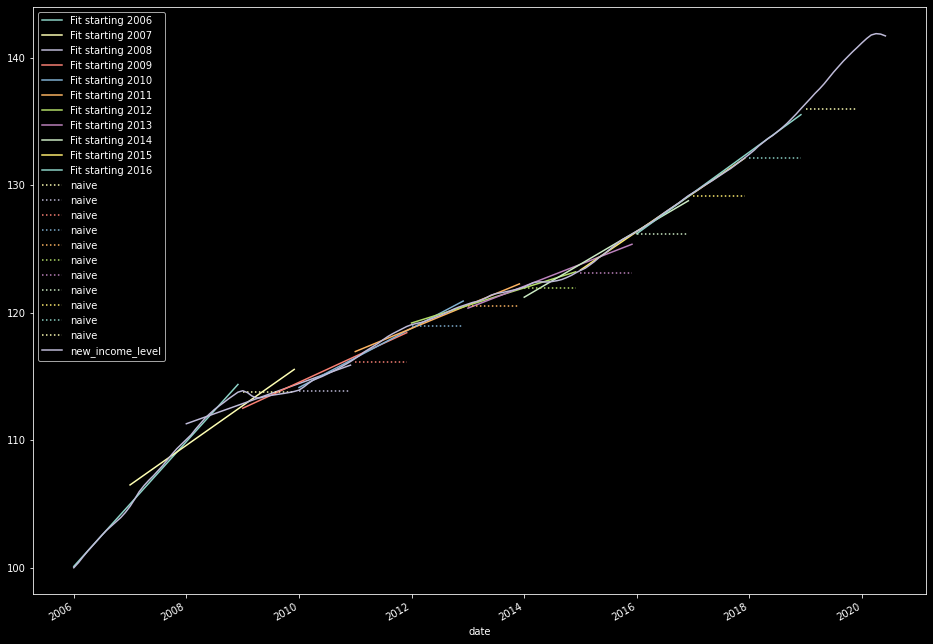

In [48]:
# fit linear trend to rolling window for prediction (same function as before)

cols = ['new_income_level', 'new_rent_level']

n = 3
start_years = list(range(min(df.index.year),max(df.index.year)-n))
fitted_lines = []

fig, ax = plt.subplots(figsize=(16,12))
final_df = df.copy()

for year in start_years:
    training_df = df.loc[str(year):str(year+(n-1)), :]
    test_df = df.loc[str(year+n), :]
    pred_df, line = predict_from_trend(training_df, test_df.index, cols[0])
    final_df = pd.concat([final_df, pred_df], axis=1)
    fitted_lines.append(line)

for year, line in zip(start_years,fitted_lines):
    ax.plot(line[0], line[1], label='Fit starting ' + str(year))
    
#final_df['pred'].plot(ax=ax, linestyle='--') -- values too high
final_df['naive'].plot(ax=ax, linestyle=':')
final_df[cols[0]].plot(ax=ax)
ax.legend()

# 6. Trend Evaluation - Temperature<a class="anchor" id="chapter6"></a>

In [55]:
def get_mae(y_true, y_hat):
    assert len(y_true) == len(y_hat)
    error = y_true - y_hat
    abs_error = error.abs()
    return round(abs_error.mean(), 4)

def get_rmse(y_true, y_hat):
    assert len(y_true) == len(y_hat)
    error = y_true - y_hat
    sq_error = error ** 2
    mean_sq_error = sq_error.mean()
    return round(mean_sq_error ** 0.5, 4)

def get_mape(y_true, y_hat):
    assert len(y_true) == len(y_hat)
    error = y_true - y_hat
    pct_error = 100*error/y_true
    ape = pct_error.abs()
    return round(ape.mean(), 4)

def get_mase(y_true, y_hat, benchmark):
    assert len(y_true) == len(y_hat)
    error = y_true - y_hat
    scaled_error = error/benchmark
    ase = scaled_error.abs()
    return round(ase.mean(), 4)

def get_benchmark_mae(y_train, forecast_horiz):
    y_pred = y_train[: -forecast_horiz] 
    # y pred is delayed by h steps: the naive forecast
    
    benchmark = get_mae(
        pd.Series(y_train[forecast_horiz:]), pd.Series(y_pred)
    )
    return round(benchmark, 4)

In [50]:
# temperature data

input_filename = os.path.join(
    data_path, 'weather', 'temperature.pickle'
)

df = pd.read_pickle(input_filename)
isna = df.isna()
print(f'10T data: there are {(isna.sum().sum())} missing values.')

10T data: there are 0 missing values.


In [52]:
daily_df = df.resample('D').mean()
daily_df['mean'] = daily_df['temp'].rolling(365).mean()

	there are (1096, 1) points
	there are (1096, 1) points
	there are (1096, 1) points


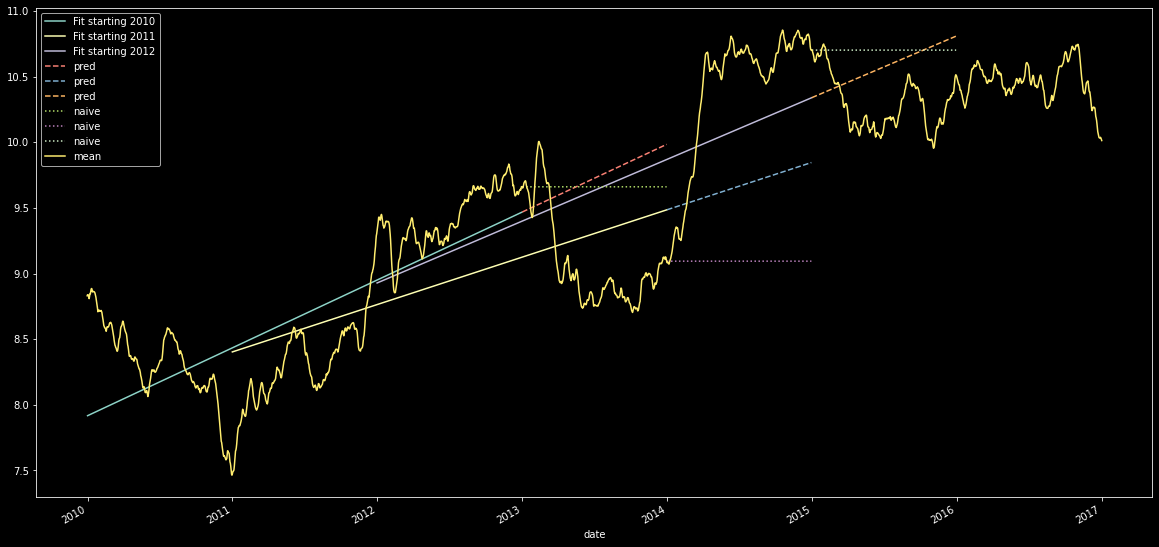

In [53]:
start_years = [2010, 2011, 2012]
n = len(start_years)

y_hat = pd.Series(np.zeros(n))
y_test = pd.Series(np.zeros(n))
y_naive = pd.Series(np.zeros(n))

fitted_lines = []

fig, ax = plt.subplots(figsize=(20,10))
final_df = daily_df.copy()

for idx, year in enumerate(start_years):
    
    training_df = daily_df.loc[str(year):str(year+2), :]
    test_df = daily_df.loc[str(year+3), :]
    pred_df, line = predict_from_trend(training_df, test_df.index)
    
    y_hat[idx] = pred_df['pred'].iloc[-1]
    y_naive[idx] = pred_df['naive'].iloc[-1]
    y_test[idx] = test_df['mean'].iloc[-1]
    
    final_df = pd.concat([final_df, pred_df], axis=1)
    fitted_lines.append(line)
    
for year, line in zip(start_years,fitted_lines):
    
    ax.plot(line[0], line[1], label='Fit starting ' + str(year))

final_df[['pred']].plot(ax=ax, linestyle='--')
final_df[['naive']].plot(ax=ax, linestyle=':')
final_df[['mean']].plot(ax=ax)
ax.legend()

In [56]:
def evaluate(y_test, y_hat):
    print(f'rmse:\t{get_rmse(y_test, y_hat)}')
    print(f'mae:\t{get_mae(y_test, y_hat)}')
    print(f'mape:\t{get_mape(y_test, y_hat)}')
    bench_mae = get_benchmark_mae(daily_df['mean'].values, 365)
    print(f'mase:\t{get_mase(y_test, y_hat, bench_mae)}')
    
print(f'Rolling trend predictions')
print(evaluate(y_test, y_hat))
print(f'Naive predictions')
print(evaluate(y_test, y_naive))

Rolling trend predictions
rmse:	0.7335
mae:	0.6813
mape:	6.8729
mase:	0.915
None
Naive predictions
rmse:	0.9904
mae:	0.7884
mape:	7.69
mase:	1.0589
None


## Further Evaluation<a class="anchor" id="section_6_1"></a>

In [57]:
# additional functions to the ones we have defined already

def predict_from_trend(training_df, test_df_index, col='mean'):
    
    y_series = training_df[col]
    y_series = y_series.dropna()
    
    # form an x series
    x_series = pd.Series(range(len(y_series)))
    
    (m, c, r_squared) = rgs.get_linear_fit(x_series, y_series)
    
    x_points = [0, x_series.iloc[-1]]
    y_points = [m * x + c for x in x_points] 
    date_points = [y_series.index[0], y_series.index[-1]]
    line = (date_points, y_points)
    
    pred_df = pd.DataFrame(index = test_df_index)

    # naive prediction
    pred_df['naive'] = y_series.iloc[-1]    

    # linear prediction
    date_zero = date_points[0]
    pred_df['pred'] = pred_df.apply(
        lambda row : m * ((row.name - date_zero).days) + c, axis=1
    )
    
    # offset prediction
    last_training_temperature = y_series.iloc[-1]
    last_training_day = y_series.index[-1]
    c_to_use = last_training_temperature
    x_zero =  last_training_day
    pred_df['offset']=test_df.apply(
        lambda row: m * ((row.name - x_zero).days) + c_to_use, axis = 1
    )
    
    return pred_df, line    

def get_trial_dates(df, training_duration='156w', forecast_horizon = '52w', stride='1w'):
    '''
    This function gives us the dates that we need to begin the time series analysis
    We use a stride of one week
    We train using 3 years of data 
    We forecast over one year. 
    Our data progresses by one week intervals.
    '''
    
    training_start = df.index[0]
    training_end = training_start + pd.Timedelta(training_duration)
    training_end_index = df.index.get_loc(training_end)

    test_start_index  =  training_end_index + 1
    test_start = df.index[test_start_index]
    forecast_horizon  = pd.Timedelta(forecast_horizon)
    test_end = test_start + pd.Timedelta(days=(forecast_horizon.days - 1)) 
    # 1 day forecast horizon: test_start==test_end

    df.index[0]
    dates = []

    stride = pd.Timedelta(stride)

    while test_end <= df.index[-1]:

        trial = {}
        trial['training_start'] = training_start
        trial['training_end'] = training_end
        trial['test_start'] = test_start
        trial['test_end'] = test_end
        dates.append(trial)

        training_start += stride
        training_end += stride
        test_start += stride
        test_end += stride
    
    return dates, forecast_horizon

In [58]:
dates, forecast_horizon = get_trial_dates(daily_df)
num_trials = len(dates)

results_shape = (num_trials, forecast_horizon.days)

results =  {
    'y_actual':np.zeros(results_shape),
    'y_linear':np.zeros(results_shape),
    'y_naive':np.zeros(results_shape),
    'y_offset':np.zeros(results_shape),
    'fitted_lines':[]
}
results_df = daily_df.copy()

for idx, trial in enumerate(dates):
    
    training_df = daily_df.loc[
        trial['training_start']:trial['training_end'], :
    ]
    
    test_df = daily_df.loc[
        trial['test_start']:trial['test_end'], :
    ]
    pred_df, line = predict_from_trend(training_df, test_df.index)
    
    results['y_actual'][idx,:] = test_df['mean'].loc[:]

    results['y_linear'][idx,:] = pred_df['pred'].iloc[:]
    results['y_naive'][idx,:] = pred_df['naive'].iloc[:]
    results['y_offset'][idx,:] = pred_df['offset'].iloc[:]
    
    results_df = pd.concat([results_df, pred_df], axis=1)
    results['fitted_lines'].append(line)

	there are (729, 1) points
	there are (736, 1) points
	there are (743, 1) points
	there are (750, 1) points
	there are (757, 1) points
	there are (764, 1) points
	there are (771, 1) points
	there are (778, 1) points
	there are (785, 1) points
	there are (792, 1) points
	there are (799, 1) points
	there are (806, 1) points
	there are (813, 1) points
	there are (820, 1) points
	there are (827, 1) points
	there are (834, 1) points
	there are (841, 1) points
	there are (848, 1) points
	there are (855, 1) points
	there are (862, 1) points
	there are (869, 1) points
	there are (876, 1) points
	there are (883, 1) points
	there are (890, 1) points
	there are (897, 1) points
	there are (904, 1) points
	there are (911, 1) points
	there are (918, 1) points
	there are (925, 1) points
	there are (932, 1) points
	there are (939, 1) points
	there are (946, 1) points
	there are (953, 1) points
	there are (960, 1) points
	there are (967, 1) points
	there are (974, 1) points
	there are (981, 1) points
	

In [59]:
print(results['y_naive'][:3,:])
print(results['y_actual'][:3,:])

[[9.25439574 9.25439574 9.25439574 ... 9.25439574 9.25439574 9.25439574]
 [9.42797146 9.42797146 9.42797146 ... 9.42797146 9.42797146 9.42797146]
 [9.45015791 9.45015791 9.45015791 ... 9.45015791 9.45015791 9.45015791]]
[[9.28769616 9.30391438 9.32606697 ... 9.63316419 9.63412785 9.64140639]
 [9.43034855 9.42367789 9.41148307 ... 9.65399258 9.6512129  9.65521005]
 [9.43869026 9.41449658 9.3885742  ... 9.70455537 9.70688166 9.69869787]]


In [60]:
# evaluate

linear_accuray = []
naive_accuracy = []
offset_accuracy = []

for day in range(1, forecast_horizon.days):
    
    benchmark_mae = get_benchmark_mae(
        daily_df['mean'].values, 
        day
    )
    
    linear_mase = get_mase(
        pd.Series(results['y_actual'][:, day]), 
        pd.Series(results['y_linear'][:, day]), 
        benchmark_mae
    )
    
    naive_mase = get_mase(
        pd.Series(results['y_actual'][:, day]), 
        pd.Series(results['y_naive'][:, day]), 
        benchmark_mae
    )
    
    offset_mase = get_mase(
        pd.Series(results['y_actual'][:, day]), 
        pd.Series(results['y_offset'][:, day]), 
        benchmark_mae
    )
    
    linear_accuray.append(linear_mase)
    naive_accuracy.append(naive_mase)
    offset_accuracy.append(offset_mase)

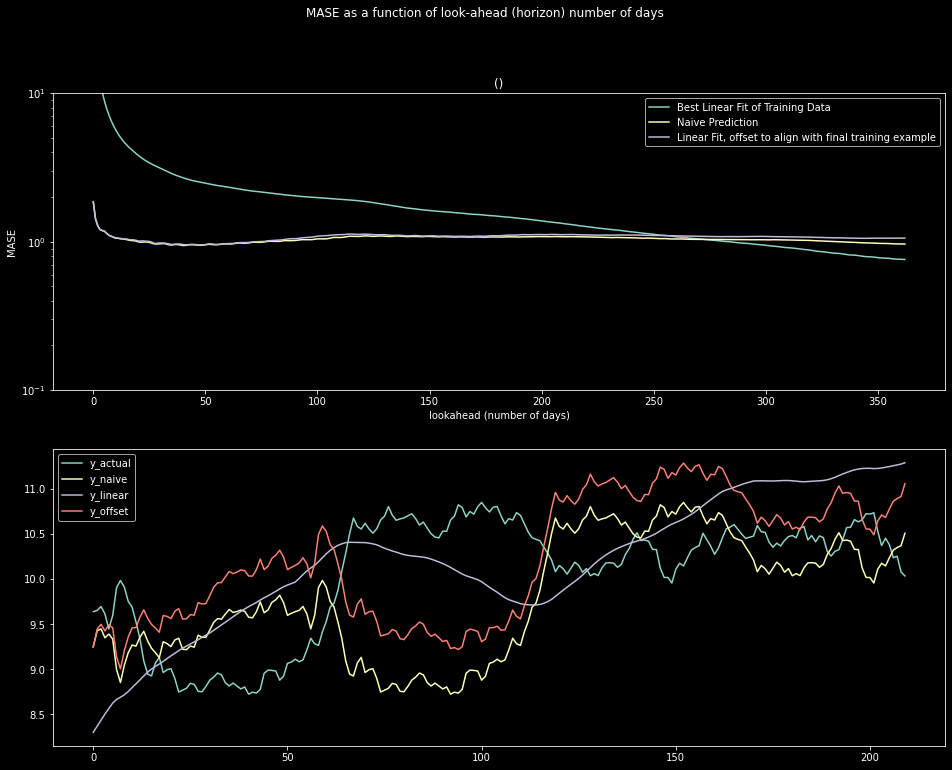

In [61]:
# plot

fig,ax_arr = plt.subplots(2,1,figsize=(16,12))
ax = ax_arr[0]

ax.plot(linear_accuray, label='Best Linear Fit of Training Data')
ax.plot(naive_accuracy, label='Naive Prediction')
ax.plot(offset_accuracy, label = 'Linear Fit, offset to align with final training example')
ax.set_ylim([0.1,10])
ax.set_yscale('log')
fig.suptitle("MASE as a function of look-ahead (horizon) number of days")
ax.set_title("()")
ax.set_xlabel("lookahead (number of days)")
ax.legend()
ax.set_ylabel('MASE')

to_plot = ['y_actual','y_naive', 'y_linear', 'y_offset']
look_ahead_idx = -1 
[ax_arr[1].plot(results[p][:,look_ahead_idx], label = p) for p in to_plot]
ax_arr[1].legend()

## Manipulating datetime indexes<a class="anchor" id="section_6_2"></a>

In [62]:
print('Dataframe frequency:', daily_df.index.freq)
print('Initial index:', daily_df.index[5])
print('1 week later:', daily_df.index[5] + daily_df.index.freq*7)

Dataframe frequency: <Day>
Initial index: 2009-01-06 00:00:00
1 week later: 2009-01-13 00:00:00


In [63]:
print('Dataframe frequency:', df.index.freq)
print('Initial index:', df.index[5])
print('1 hour later:', df.index[5] + df.index.freq*6)

Dataframe frequency: <10 * Minutes>
Initial index: 2009-01-01 01:00:00
1 hour later: 2009-01-01 02:00:00


# 7. Decomposition - Temperature<a class="anchor" id="chapter7"></a>

Perform a classical decomposition of the temperature time series, using weekly and yearly periods as necessary.



The following tasks are suggested to decompose the 'temperature' signal:
- estimate a trend component, by using a linear fit on a rolling mean.
- plot trend component, and the residual signal (from that 'trend' component).
- using that residual, estimate a yearly seasonal component, by modelling the expected  temperature at monthly intervals
- plot the combined trend and yearly components, and also the residual signal (by subtracting this combination from the original temperature signal.)
- estimate a daily seasonal component, by modelling demand at hourly intervals. 
- plot the combined trend, yearly and daily components, and also the residual signal.
- For the final residual of all signals, find the variance, and plot the auto-correlation. Compare against original signal. - Create a decomposition model that has a 'predict' method, giving the value of the seasonal signal for a given date. 

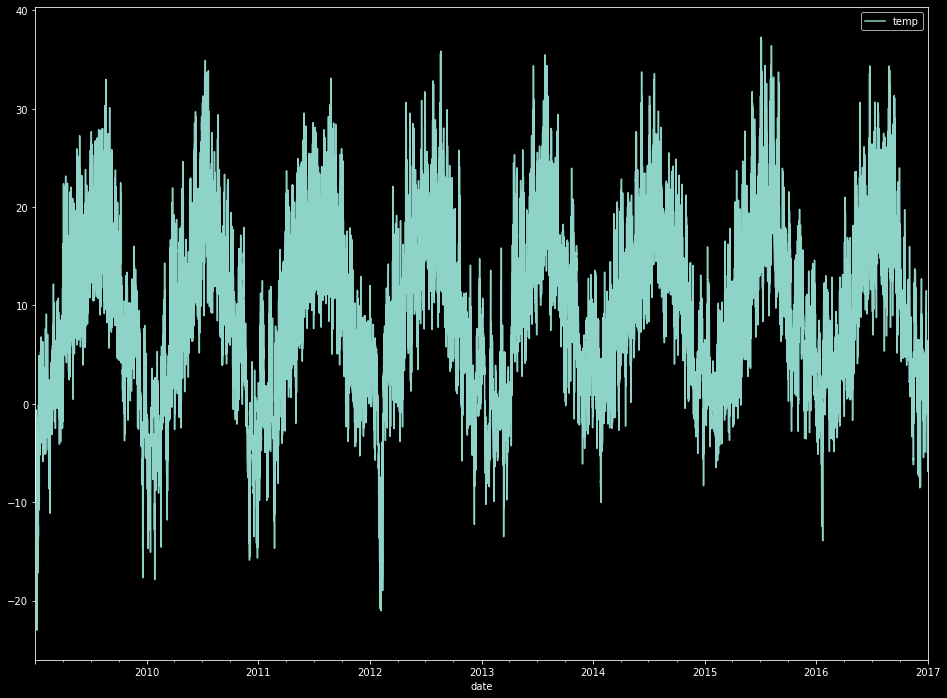

In [64]:
input_filename = os.path.join(
    data_path, 'weather', 'temperature.pickle'
)

output_filename = os.path.join(
    data_path, 'weather', 'temperature_decomposition.pickle'
)

fig_filename = os.path.join(
    data_path, 'weather', 'temperature_decomposition.png'
)

df = pd.read_pickle(input_filename)
df.plot(figsize=(16, 12));

## Decomposition model class<a class="anchor" id="section_7_1"></a>

Initially takes no arguments to call the class and this has a predict method

We are using monthly models to model the yearly variation and hourly models to model the daily variation

He we can see how the residual is composed of the linear error, the monthly error and the hourly error

In [65]:
class DecompositionModel:
    
    def __init__(
        self, linear_model = None, monthly_model=None, hourly_model=None
    ):
        self.linear_model = linear_model
        self.monthly_model= monthly_model
        self.hourly_model = hourly_model
    
    def predict(self, date_to_predict):
        yhat = 0.0
       
        if self.linear_model is not None:
            
            x_timedelta = date_to_predict - self.linear_model[2]
            x = x_timedelta.days
            linear_yhat = self.linear_model[0] * x + self.linear_model[1]
            yhat += linear_yhat
           
        if self.monthly_model is not None:
            
            month = date_to_predict.month
            monthly_yhat = self.monthly_model[month]
            yhat += monthly_yhat
           
        if self.hourly_model is not None:

            hour = date_to_predict.hour
            hourly_yhat = self.hourly_model[hour]
            yhat += hourly_yhat
           
        return yhat

## Linear trend component<a class="anchor" id="section_7_2"></a>

- We import our linear regression from kubrick_tsa folder

- Here we take an input signal, create two new columns (one we preappend a t and one we append a model_t).

- We construct the training and testing dataframes as we have in previous workbooks. Notice the usage of ilocto remove the last row of the training data which we have because of the usage of loc in the previous line.

- x represents an sequence of integers beginning at zero and represents the movement of time.

- linear trend is found using the linear formula applied to the train_and_test_df

- residual is found by subtracting our trend from the original signal, which we then concatenate with the train_and_test_df

- the linear model parameters are returned along with the datetime index obtained from x


In [66]:
def add_linear_trend_component(training_and_test_df, training_start, test_start, signal):
    
    signals = [
        signal, # the original
        't_' + signal, # the residual (after removing trend)
        signal + '_model_t' # the trend model
    ] 
    
    x = pd.Series(
        list(range(training_and_test_df.shape[0])), 
        index = training_and_test_df.index, 
        name = 'x'
    )
    
    training_and_test_df = pd.concat([training_and_test_df, x], axis=1)
    
    training_df = training_and_test_df.loc[training_start:test_start, :]
    training_df = training_df.iloc[:-1, :] # remove last row

    test_df = training_and_test_df.loc[test_start:, :]
    
    x_train = training_df['x']
    y_train = training_df[signal]
    print(f'size of x and y train: {len(x_train)}, {len(y_train)} ')
    print(f'shape of x and y train: {x_train.shape}, {y_train.shape} ')
    m, c, r_squared = rgs.get_linear_fit(x_train,y_train)
    
    trend = pd.DataFrame(
        {
            signals[2] : training_and_test_df.apply(
                lambda row: m * row.x + c, axis=1
            )
        }
    )
    
    training_and_test_df = pd.concat([training_and_test_df, trend], axis=1)

    residual = pd.DataFrame(
        {
            signals[1] : (
                training_and_test_df[signals[0]] - 
                training_and_test_df[signals[2]]
            )
        }
    )
    
    training_and_test_df = pd.concat([training_and_test_df, residual], axis=1)
    
    training_and_test_df = training_and_test_df.drop(columns=['x'])
    linear_model = (m, c, x.index[0])
    
    return training_and_test_df, signals, linear_model 

## Monthly trend component<a class="anchor" id="section_7_3"></a>

- The signal we take in to the function is the residual after removing the linear trend (the dataframe column residual above, called t_Temp in this case)

- It is the same in structure as the linear trend model.

- We construct a model using a groupby aggregation.

- We find the monthly seasonal component in the same way we find the linear trend above, applying the model to the dataframe

- We also create the residual component in a similar way, we have removed the linear trend and the monthly component

- The dataframes are then concatenated with the train_and_test_df

In [67]:
def add_monthly_seasonal_component(
    training_and_test_df, training_start, test_start, signal
):
    
    signals = [
        signal, # the original
        'm_' + signal, # the residual (after removing trend)
        signal + '_model_m' # the monthly model
    ]
    
    print(training_and_test_df.columns)
    training_df = training_and_test_df.loc[training_start:test_start, :]
    
    training_df = training_df.iloc[:-1, :] #remove last row
    
    model = training_df.groupby('Month')[signal].mean()

    test_df = training_and_test_df.loc[test_start:, :]
    
    msc = pd.DataFrame(
        {
            signals[2]: training_and_test_df.apply(
                lambda row: model[row.Month], axis=1
            )
        }
    )
    
    training_and_test_df = pd.concat([training_and_test_df, msc], axis=1)
    
    residual = pd.DataFrame(
        {
            signals[1]: (
                training_and_test_df[signals[0]] - 
                training_and_test_df[signals[2]]
            )
        }
    )
    
    training_and_test_df = pd.concat([training_and_test_df, residual], axis=1)
                                             
    return training_and_test_df, signals, model 

## Hourly trend component<a class="anchor" id="section_7_4"></a>

- Is very similar to the monthly component above.

- Our model is the mean temperature for the hour

- Our residual term now has the linear trend, monthly component ad now hourly component removed

In [68]:
def add_hourly_seasonal_component(
    training_and_test_df, training_start, test_start, signal
):
    
    signals = [
        signal, # the input
        'h_' + signal, # the hourly residual
        signal + '_model_h' # the hourly model
    ]
    
    print(training_and_test_df.columns)
    training_and_test_df['hour'] = df.index.hour
    training_df = training_and_test_df.loc[training_start:test_start, :]
    
    training_df = training_df.iloc[:-1, :] #remove last row
    
    model = training_df.groupby('hour')[signal].mean()

    test_df = training_and_test_df.loc[test_start:, :]
    
    hsc = pd.DataFrame(
        {
            signals[2]: training_and_test_df.apply(
                lambda row: model[row.hour], axis=1
            )
        }
    )
    
    training_and_test_df = pd.concat([training_and_test_df, hsc], axis=1)
    
    residual = pd.DataFrame(
        {
            signals[1]: (
                training_and_test_df[signals[0]] - 
                training_and_test_df[signals[2]]
            )
        }
    )
    
    training_and_test_df = pd.concat([training_and_test_df, residual], axis=1)
    
                                         
    return training_and_test_df, signals, model

## Data Pipeline<a class="anchor" id="section_7_5"></a>

In [70]:
training_starts = ['2009-01-01']
test_starts = ['2015-01-01']

signals = ['temp']
output = {s:[] for s in signals} 
models = {s:DecompositionModel() for s in signals}

# trend:

input_signals = signals

for (
    s, 
    input_signal, 
    training_start, 
    test_start
) in zip(signals, input_signals, training_starts, test_starts):
    (
        df, 
        output_signals, 
        linear_model
    ) = add_linear_trend_component(
        df, training_start, test_start, input_signal
    )
    
    output[s].append(output_signals)
    models[s].linear_model = linear_model

# monthly seasonal:

df['Month'] = df.index.month
input_signals = ['t_' + s for s in signals]
_ = [ output[s][-1][1] for s in signals]
assert input_signals == _

for (
    s, 
    input_signal, 
    training_start, 
    test_start
) in zip(signals, input_signals, training_starts, test_starts):
    (
        df, 
        output_signals, 
        monthly_model
    ) = add_monthly_seasonal_component(
        df, training_start, test_start, input_signal
    )
    output[s].append(output_signals)
    models[s].monthly_model = monthly_model 

# hourly seasonal:

input_signals = ['m_t_' + s for s in signals]
_ = [output[s][-1][1] for s in signals]
assert input_signals == _
 
for (
    s, 
    input_signal, 
    training_start, 
    test_start
) in zip(signals, input_signals, training_starts, test_starts):
    (
        df, 
        output_signals, 
        hourly_model
    ) = add_hourly_seasonal_component(
        df, training_start, test_start, input_signal
    )
    
    output[s].append(output_signals)
    models[s].hourly_model = hourly_model
    

print('the columns:')
print(df.columns)
print('the columns:')
print(output)

size of x and y train: 315646, 315646 
shape of x and y train: (315646,), (315646,) 
	there are (315646, 1) points
Index(['temp', 'temp_model_t', 't_temp', 'Month'], dtype='object')
Index(['temp', 'temp_model_t', 't_temp', 'Month', 't_temp_model_m',
       'm_t_temp'],
      dtype='object')
the columns:
Index(['temp', 'temp_model_t', 't_temp', 'Month', 't_temp_model_m', 'm_t_temp',
       'hour', 'm_t_temp_model_h', 'h_m_t_temp'],
      dtype='object')
the columns:
{'temp': [['temp', 't_temp', 'temp_model_t'], ['t_temp', 'm_t_temp', 't_temp_model_m'], ['m_t_temp', 'h_m_t_temp', 'm_t_temp_model_h']]}


## Ouput analysis<a class="anchor" id="section_7_6"></a>

- First row is the data, the residual after removing the linear trend and the model for linear trend

- Second row is the residual after removing linear trend, residual after also removing the monthly trend and the model for monthly trend

- 3rd row is similar to the second but in the hourly context

In [71]:
models['temp']

In [72]:
# recompose the decomposition

pred_signals = ['pred_' + s for s in signals]
residual_signals = ['res_' + s for s in signals]

for s, pred, res in zip(signals, pred_signals, residual_signals):
    
    df[pred] = 0.0
    
    for stage in output[s]:
        
        df[pred] += df[stage[2]] 
        # [2] is the last  of the triple, that holds the model
        
    df[res] = df[s] - df[pred]

<AxesSubplot:xlabel='date'>

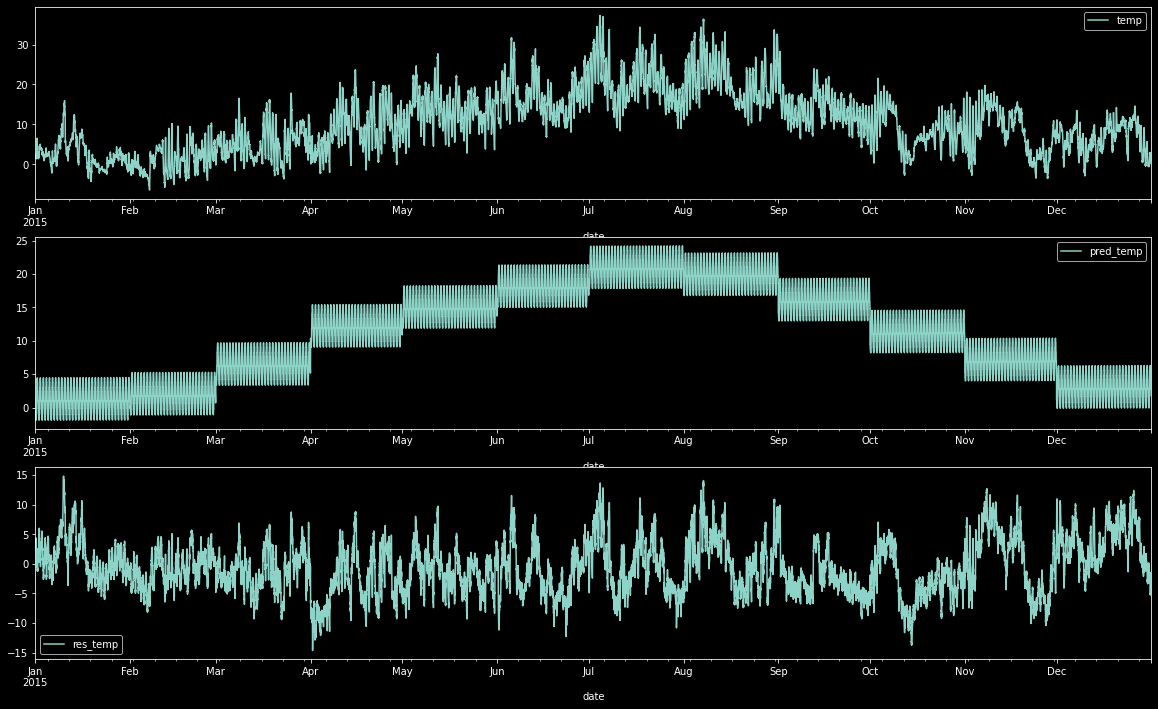

In [73]:
# plot

fig, ax = plt.subplots(3, 1, figsize=(20, 12))

year_to_plot = '2015'

y_actuals = signals.copy();
y_preds = ['pred_' + s for s in signals]
y_resids = ['res_' + s for s in signals]
#y_resids= ['m_t_Consumption_model_d',  't_Wind_model_m', 't_Solar_model_m']
df.loc[year_to_plot,y_actuals].plot(ax=ax[0])
df.loc[year_to_plot,y_preds].plot(ax=ax[1])
df.loc[year_to_plot,y_resids].plot(ax=ax[2])

Mean residual: res_temp   -0.609688
dtype: float64


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

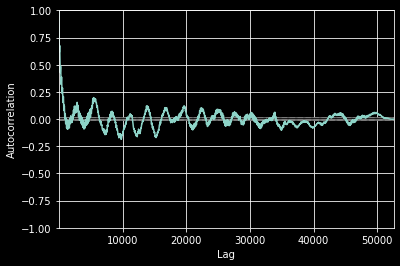

In [74]:
print('Mean residual:', df.loc[year_to_plot,y_resids].mean())
pd.plotting.autocorrelation_plot(df.loc[year_to_plot,y_resids])

In [75]:
df.to_pickle(output_filename)
fig.savefig(fig_filename)

## Generate Predicitions<a class="anchor" id="section_7_7"></a>

- This will make temperature predictions for a year

(8761, 1)


,pred
2016-12-30 20:00:00,-0.413407
2016-12-30 21:00:00,-1.050723
2016-12-30 22:00:00,-1.622728
2016-12-30 23:00:00,-2.130773
2016-12-31 00:00:00,-2.598530


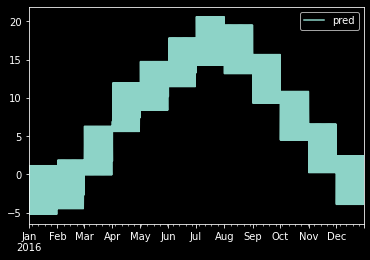

In [77]:
start_date = pd.Timestamp('2016-01-01')

days = pd.date_range(
    start_date, 
    start_date + timedelta(days=365), 
    freq='h'
)
predictions = [models['temp'].predict(d) for d in days]

pred_df = pd.DataFrame({'pred': predictions}, index=days)
print(pred_df.shape)
#pred_df['naive'] = df.apply(lambda row : models['Consumption'].predict(row.index.name), axis=1)
pred_df.plot()

#models['Consumption'].predict(pd.Timestamp('2007-0-03'))
pred_df.tail()

# 8. Decomposition - Power<a class="anchor" id="chapter8"></a>

Perform a classical decomposition of the power time series, using weekly and yearly periods as necessary.

The following tasks are suggested for all three signals ('Consumption', 'Solar' and 'Wind'):
- estimate a trend component, by using a linear fit on a rolling mean.
- plot trend component, and the residual signal (from that 'trend' component)
- using that residual, estimate a yearly seasonal component, by modelling the expected seasonal power
- plot the combined trend and yearly components, and also the residual signal (by subtracting this combination from the original signal.)

The following tasks are suggested for the 'Consumption' signal:
- estimate a weekly seasonal component, by modelling demand at each day of the week.
- plot the combined trend, yearly and weekly components, and also the residual signal

For the final residual of all signals, find the variance, and plot the auto-correlation. Compare against original signal.

Create a decomposition model that has a 'predict' method, giving the value of the seasonal signal for a given date. 

Save the model class and the residual time seres as pickle files 

In [78]:
input_filepath = os.path.join(
    data_path, 'power', 'german_daily_power.pickle'
)

output_df_filepath = os.path.join(
    data_path, 'power', 'power_decomposition_df.pickle'
)
# asfreq dataframe
# we'll also store the decomposition model, one per signal

df = pd.read_pickle(input_filepath)
display(df)

,Consumption,Wind,Solar,Wind + Solar,month,year,weekday
Date,,,,,,,
2006-01-01,1069.18400,NaN,NaN,NaN,1,2006,Sunday
2006-01-02,1380.52100,NaN,NaN,NaN,1,2006,Monday
2006-01-03,1442.53300,NaN,NaN,NaN,1,2006,Tuesday
2006-01-04,1457.21700,NaN,NaN,NaN,1,2006,Wednesday
2006-01-05,1477.13100,NaN,NaN,NaN,1,2006,Thursday
...,...,...,...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037,12,2017,Wednesday
2017-12-28,1299.86398,506.424,14.162,520.586,12,2017,Thursday
2017-12-29,1295.08753,584.277,29.854,614.131,12,2017,Friday


In [79]:
def add_rolling_trend_component(
    training_df, signal
):
    signals = [
        signal, # the original
        'r_' + signal, # the trend
        signal + '_model_r' # the residual
    ]
    
    
    training_df[signals[1]] = training_df[signal].rolling(365, center=True).mean()
    training_df[signals[2]] = training_df[signal] - training_df[signals[1]]

    return training_df, signals

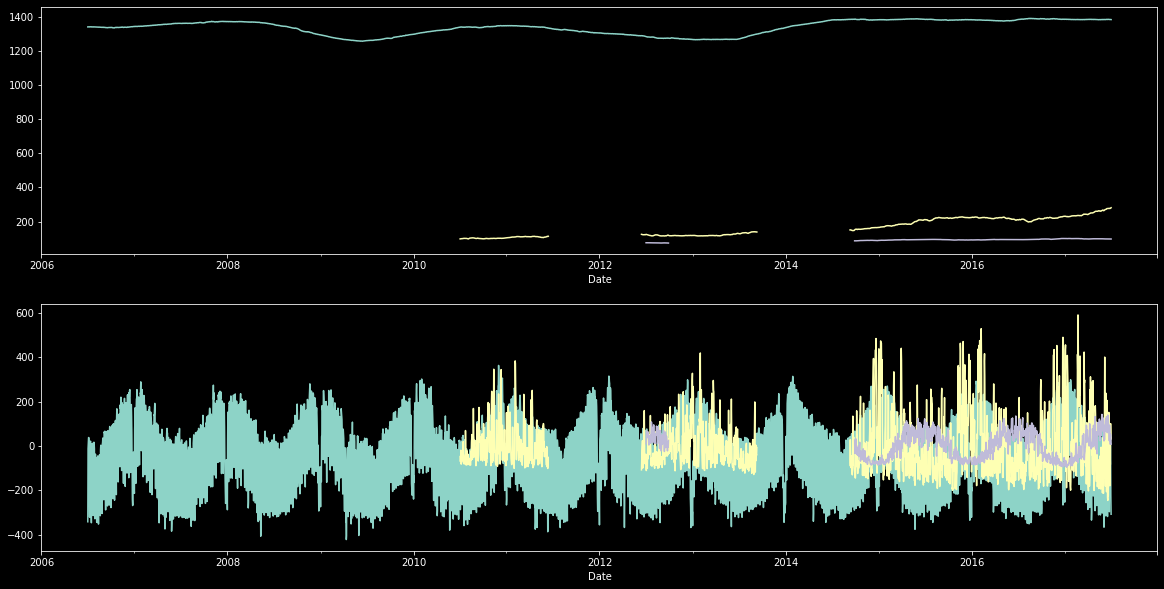

In [81]:
our_signals = ['Consumption', 'Wind', 'Solar']

fig, ax = plt.subplots(2, 1, figsize=(20,10))

for signal in our_signals:
    
    df, signals = add_rolling_trend_component(df, signal)
    df[signals[1]].plot(ax=ax[0])
    df[signals[2]].plot(ax=ax[1])

In [82]:
# slightly redefine some of these fcts.

def get_linear_fit(x_series,y_series):
    
    x = x_series.values.reshape(-1,1)
    y = y_series.values.reshape(-1,1)
    print(f'\tthere are {x.shape} points')
    
    lr = LinearRegression()
    lr = lr.fit(x, y)    
    m = lr.coef_[0][0]
    c = lr.intercept_[0]    
    r_squared = lr.score(x,y)
    
    return m,c,r_squared

def add_monthly_seasonal_component(training_and_test_df, training_start, test_start, signal):
    
    signals = [signal,              # the original
               'm_' + signal,       # the residual (after removing trend)
               signal + '_model_m'] # the monthly model
    
    print(training_and_test_df.columns)
    training_df = training_and_test_df.loc[training_start:test_start, :]
    
    training_df = training_df.iloc[:-1, :] #remove last row
    
    model = training_df.groupby('month')[signal].mean()
    
    #monthly_seasonal_component = monthly_gb.transform(np.mean)

    test_df = training_and_test_df.loc[test_start:, :]
    
    msc = pd.DataFrame({signals[2]:training_and_test_df.apply(lambda row: model[row['month']], axis=1)})
    training_and_test_df = pd.concat([training_and_test_df, msc], axis=1)
    
    residual = pd.DataFrame({signals[1]:training_and_test_df[signals[0]]-training_and_test_df[signals[2]]})
    training_and_test_df = pd.concat([training_and_test_df, residual], axis=1)
                                             
    return training_and_test_df, signals, model

def add_daily_seasonal_component(training_and_test_df, training_start, test_start, signal):
    
    signals = [signal,            # the original
               'd_' + signal,     # the daily residual
               signal + '_model_d'] # the daily model
    
    print(training_and_test_df.columns)
    #training_and_test_df['Weekday'] = df.index.day_name()
    training_df = training_and_test_df.loc[training_start:test_start, :]
    
    training_df = training_df.iloc[:-1, :] #remove last row
    
    model = training_df.groupby('weekday')[signal].mean()
    
    #monthly_seasonal_component = monthly_gb.transform(np.mean)

    test_df = training_and_test_df.loc[test_start:, :]
    
    msc = pd.DataFrame({signals[2]:training_and_test_df.apply(lambda row: model[row['weekday']], axis=1)})
    training_and_test_df = pd.concat([training_and_test_df, msc], axis=1)
    
    residual = pd.DataFrame({signals[1]:training_and_test_df[signals[0]]-training_and_test_df[signals[2]]})
    training_and_test_df = pd.concat([training_and_test_df, residual], axis=1)
    
                                         
    return training_and_test_df, signals, model

In [83]:
df = df.dropna()

training_starts = ['2006-01-01', '2010-01-01', '2012-01-01']
test_starts = ['2016-01-01', '2016-01-01', '2016-01-01']              

signals = ['Consumption', 'Wind', 'Solar']
output = {s:[] for s in signals} 
models = {s:DecompositionModel(hourly_model=None) for s in signals}

# linear trend:

input_signals = signals
for s, input_signal, training_start, test_start in zip(
    signals, input_signals, training_starts, test_starts
):
    df, output_signals, linear_model = add_linear_trend_component(
        df, training_start, test_start, input_signal
    )
    
    output[s].append(output_signals)
    models[s].linear_model = linear_model

# monthly seasonal:

input_signals = ['t_' + s for s in signals]
_ = [ output[s][-1][1] for s in signals]
assert input_signals == _

for s, input_signal, training_start, test_start in zip(
    signals, input_signals, training_starts, test_starts
):
    df, output_signals, monthly_model = add_monthly_seasonal_component(
        df, training_start, test_start, input_signal
    )
    
    output[s].append(output_signals)
    models[s].monthly_model = monthly_model
    

# daily seasonal:

input_signals = ['m_t_' + s for s in signals]
_ = [output[s][-1][1] for s in signals]
assert input_signals == _

for s, input_signal, training_start, test_start in zip(
    signals, input_signals, training_starts, test_starts
):
    if s != 'Consumption': # ONLY do Consumption, i.e. not wind or solar
        continue
    df, output_signals, daily_model = add_daily_seasonal_component(
        df, training_start, test_start, input_signal
    )
    
    output[s].append(output_signals)
    models[s].daily_model = daily_model

print('the columns:')
print(df.columns)
print('the columns:')
print(output)

size of x and y train: 548, 548 
shape of x and y train: (548,), (548,) 
	there are (548, 1) points
size of x and y train: 548, 548 
shape of x and y train: (548,), (548,) 
	there are (548, 1) points
size of x and y train: 548, 548 
shape of x and y train: (548,), (548,) 
	there are (548, 1) points
Index(['Consumption', 'Wind', 'Solar', 'Wind + Solar', 'month', 'year',
       'weekday', 'r_Consumption', 'Consumption_model_r', 'r_Wind',
       'Wind_model_r', 'r_Solar', 'Solar_model_r', 'Consumption_model_t',
       't_Consumption', 'Wind_model_t', 't_Wind', 'Solar_model_t', 't_Solar'],
      dtype='object')
Index(['Consumption', 'Wind', 'Solar', 'Wind + Solar', 'month', 'year',
       'weekday', 'r_Consumption', 'Consumption_model_r', 'r_Wind',
       'Wind_model_r', 'r_Solar', 'Solar_model_r', 'Consumption_model_t',
       't_Consumption', 'Wind_model_t', 't_Wind', 'Solar_model_t', 't_Solar',
       't_Consumption_model_m', 'm_t_Consumption'],
      dtype='object')
Index(['Consumption

(366, 1)


,pred
2016-12-27,1580.312219
2016-12-28,1580.456547
2016-12-29,1580.600876
2016-12-30,1580.745204
2016-12-31,1580.889532


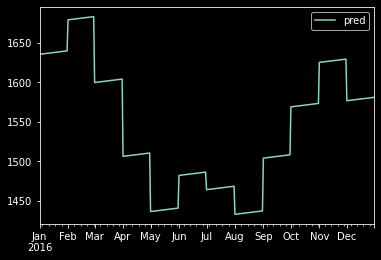

In [84]:
# predictions

start_date = pd.Timestamp('2016-01-01')

days = pd.date_range(start_date, start_date + timedelta(days=365), freq='D')
predictions = [models['Consumption'].predict(d) for d in days]

pred_df = pd.DataFrame({'pred':predictions}, index=days)
print(pred_df.shape)
#pred_df['naive'] = df.apply(lambda row : models['Consumption'].predict(row.index.name), axis=1)
pred_df.plot()

#models['Consumption'].predict(pd.Timestamp('2007-0-03'))
pred_df.tail()

In [85]:
# recompose the decomposition

pred_signals = ['pred_' + s for s in signals]
residual_signals = ['res_' + s for s in signals]
for s, pred, res in zip(signals, pred_signals, residual_signals):
    df[pred] = 0.0
    for stage in output[s]:
        df[pred] += df[stage[2]] # [2] is the last  of the triple, that holds the model 
    df[res] = df[s]-df[pred]
    
df.to_pickle(open(output_df_filepath, 'wb'))

<AxesSubplot:xlabel='Date'>

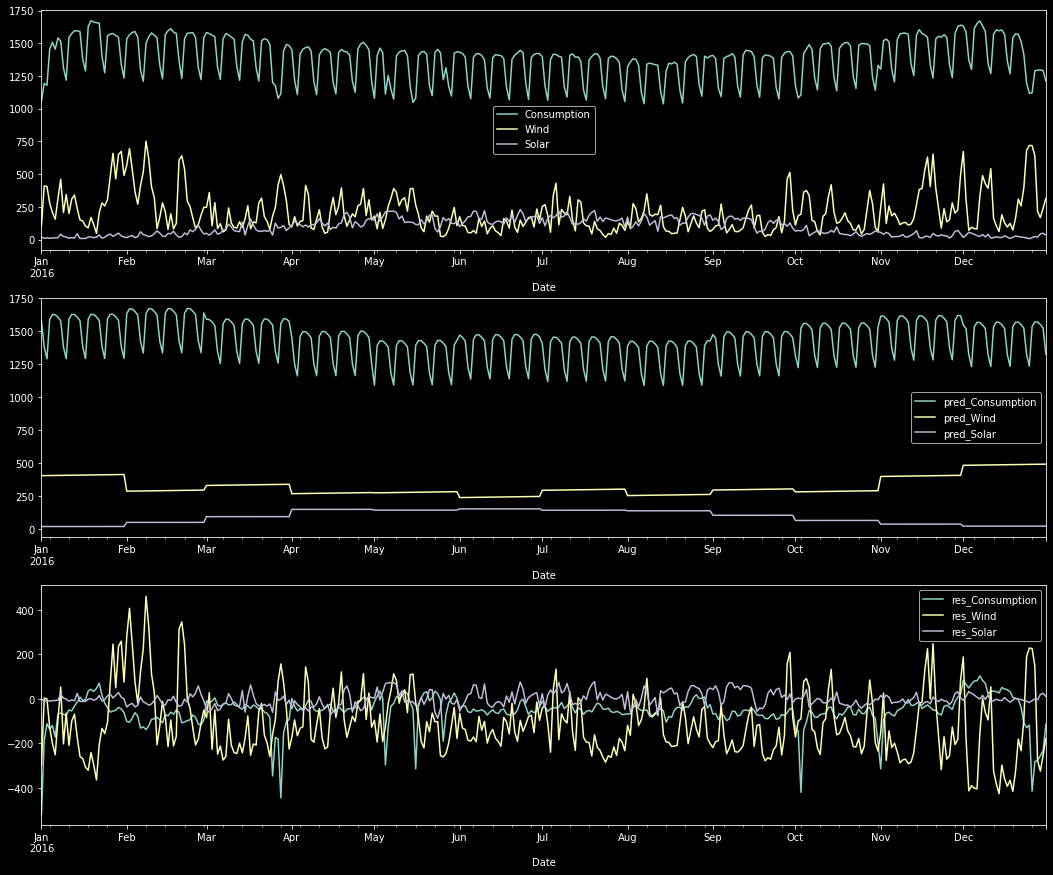

In [86]:
# plot results: 

fig,ax=plt.subplots(3,1,figsize=(18,15))

year_to_plot = '2016'

y_actuals = signals.copy();
y_preds = ['pred_' + s for s in signals]
y_resids = ['res_' + s for s in signals]
#y_resids= ['m_t_Consumption_model_d',  't_Wind_model_m', 't_Solar_model_m']
df.loc[year_to_plot,y_actuals].plot(ax=ax[0])
df.loc[year_to_plot,y_preds].plot(ax=ax[1])
df.loc[year_to_plot,y_resids].plot(ax=ax[2])

# pd.plotting.autocorrelation_plot(s, ax=ax[3])

In [87]:
for s in signals:
    output_model_filepath = os.path.join(
        data_path, 'power', f'{s}_decomposition_model.pickle'
    )
    pickle.dump(models[s], open(output_model_filepath, 'wb'))

# 9. Synthetic AR Models<a class="anchor" id="chapter9"></a>

## AR(1)<a class="anchor" id="section_9_1"></a>

- AR(1) means 'Autoregressive with one lagged variable' 
- that has a single method get_y_t(), that generates the next sample in the series 
- Use a zero-mean, unit-s.d. normal distribution, for the noise term.
- use the AutoReg class from StatsModels to estimate its paramaters

Text(0.5, 1.0, 'AR(1) process with c=20 and phi_1=-0.4')

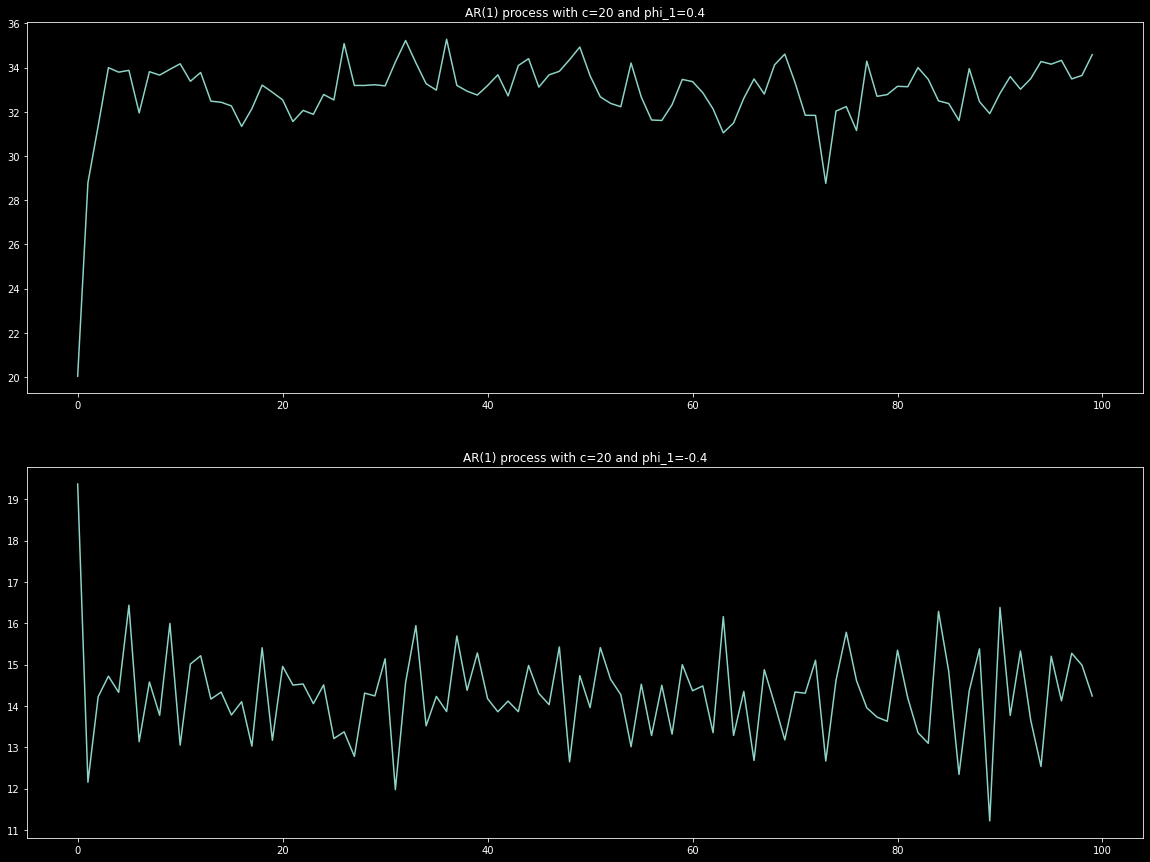

In [88]:
class ArOne:
    def __init__(self, c, phi1):
        self.c = c
        self.phi1 = phi1
        self.y_t_minus_one = 0
        
    def get_y_t(self):
        noise = np.random.normal()
        y_t = self.c + self.y_t_minus_one * self.phi1 + noise
        self.y_t_minus_one = y_t
        return y_t
    
    def get_title(self):
        return f'AR(1) process with c={self.c} and phi_1={self.phi1}'

ar1_process = ArOne(20, 0.4)
ar1_process2 = ArOne(20, -0.4)
t = 100
time_series = [ar1_process.get_y_t() for i in range(t)]
time_series2 = [ar1_process2.get_y_t() for i in range(t)]

fig, ax = plt.subplots(2,1,figsize=(20, 15))
ax[0].plot(time_series)
ax[0].set_title(ar1_process.get_title())
ax[1].plot(time_series2)
ax[1].set_title(ar1_process2.get_title())

In [89]:
# estimate params

model = AutoReg(time_series, 1, 'c')
model_results = model.fit()

print(model_results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  100
Model:                     AutoReg(1)   Log Likelihood                -134.316
Method:               Conditional MLE   S.D. of innovations              0.940
Date:                Sat, 04 Jun 2022   AIC                            274.633
Time:                        20:37:07   BIC                            282.418
Sample:                             1   HQIC                           277.783
                                  100                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.9422      1.815     11.538      0.000      17.385      24.500
y.L1           0.3674      0.055      6.663      0.000       0.259       0.475
                                    Roots           

## AR(2)<a class="anchor" id="section_9_2"></a>

- AR(2) means 'Autoregressive with two lagged variables' 
- that has a  method get_y_t(), that generates the next sample in the series, and say a 'get_title' method
- Use a zero-mean, unit-s.d. normal distribution, for the noise term.
- use the AutoReg class from StatsModels to estimate its parameters

Text(0.5, 1.0, 'AR(2) process with c=20 and phi_1=-1.4and phi_2=0.7')

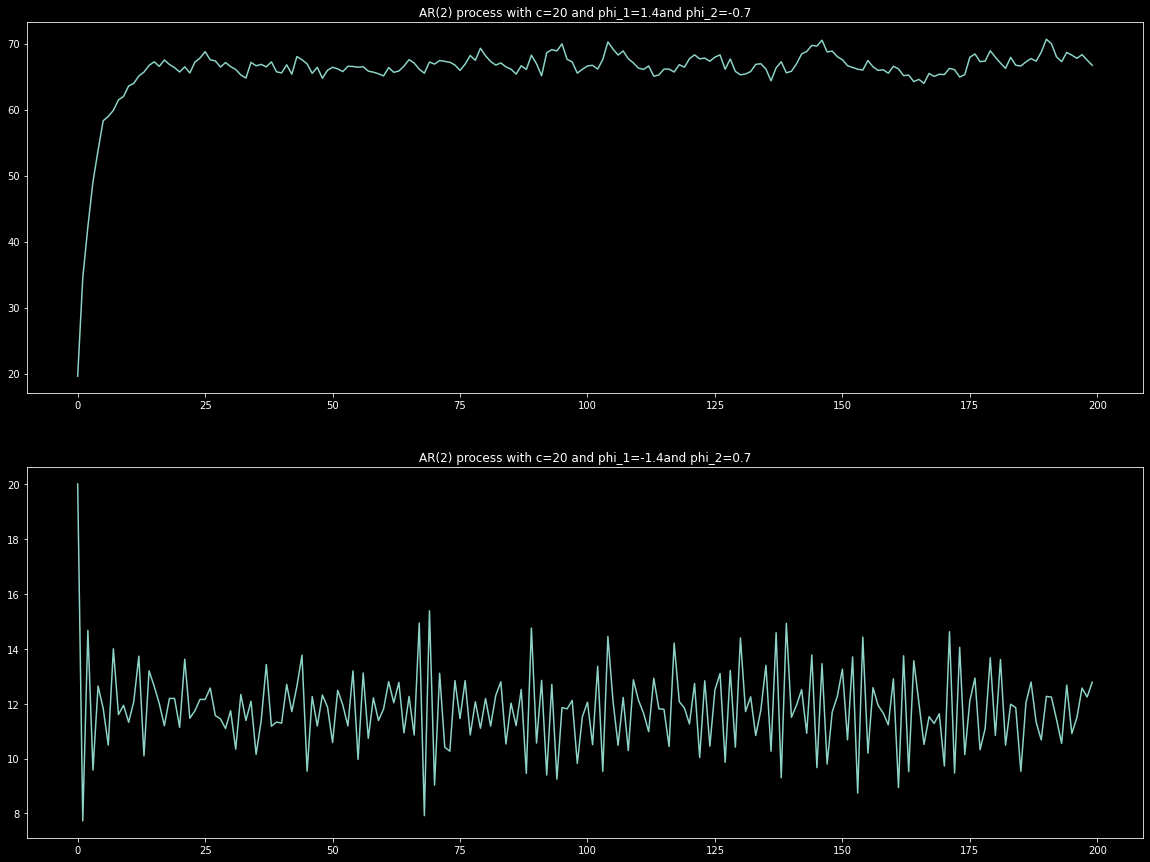

In [90]:
import numpy as np
import matplotlib.pyplot as plt

class ArTwo:
    def __init__(self, c, phi1, phi2):
        self.c             = c
        self.phi1          = phi1
        self.phi2          = phi2
        self.y_t_minus_one = 0
        self.y_t_minus_two = 0
        
    def get_y_t(self):
        noise              = np.random.normal()
        y_t                = self.c + self.y_t_minus_one * self.phi1 + self.y_t_minus_two * self.phi2 + noise
        self.y_t_minus_one = y_t
        self.y_t_minus_two = self.y_t_minus_one
        return y_t
    
    def get_title(self):
        return f'AR(2) process with c={self.c} and phi_1={self.phi1}and phi_2={self.phi2}'
  

ar2_process = ArTwo(20, 1.4, -0.7)
ar2_process2 = ArTwo(20, -1.4, 0.7)
t = 200
time_series = [ar2_process.get_y_t() for i in range(t)]
time_series2 = [ar2_process2.get_y_t() for i in range(t)]

fig, ax = plt.subplots(2,1,figsize=(20,15))
ax[0].plot(time_series)
ax[0].set_title(ar2_process.get_title())
ax[1].plot(time_series2)
ax[1].set_title(ar2_process2.get_title())

In [91]:
model = AutoReg(time_series, 2, 'c')
model_results = model.fit()

print(model_results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  200
Model:                     AutoReg(2)   Log Likelihood                -266.690
Method:               Conditional MLE   S.D. of innovations              0.931
Date:                Sat, 04 Jun 2022   AIC                            541.379
Time:                        20:37:19   BIC                            554.532
Sample:                             2   HQIC                           546.703
                                  200                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.0150      1.606     11.842      0.000      15.868      22.162
y.L1           0.6375      0.070      9.107      0.000       0.500       0.775
y.L2           0.0781      0.052      1.508      0.1

# 10. Forecasting - Power<a class="anchor" id="chapter10"></a>

Evaluate temperature forecast performance using:

- naive 'model'
- seasonal model
- offset seasonal model
- facebook prophet (not done here as Prophet install keeps failing)
- AR() process


Suggested activities:

**Diagnostics:**
- check that naive predictions are convincing, i.e. explain lower graph shapes given that expect naive forecast to be an offset version of the actual values.

**Investigations into Prophet accuracy:**
- scale up the experiments to get best use out of the available data.
- add german holidays to the prophet model.
- report on absolute levels of accuracy, i.e. what is the forecast error in terms of MW/h?
- report on accuracy of Wind and Solar prediction


**Investigations into AR (and other StatsModels classes) accuracy:**
- instead of working with the seasonal residual, input the original signal directly into the AR model. Set seasonal_dummies to be true. 
- try using the StatsModels ARIMA (or SARIMA) class, intead of AutoReg. 

**Refactoring:**

- write a 'fit' method for the seasonal model (using the code from 'decompose power', developed yesterday). This way, we don't rely on the seasonal model pickle file. 
- Currently, the forecast methods are explicitly called, in the main loop over trials. Refactor this so that a list of forecast methods is used, each eith its own 'predict_from' method. 


In [92]:
# evaluation measures

# from fbprophet import Prophet

pd.plotting.register_matplotlib_converters()


def predict_from_naive(training_df, test_df_index, input_col, output_col):
    last_training_y_val = training_df[input_col].iloc[-1]
    pred_df = pd.DataFrame(index = test_df_index)
    pred_df[output_col] = last_training_y_val
    return pred_df
    
def predict_from_trend(training_df, test_df_index, input_col, output_col):
    y_series = training_df[input_col]
    y_series = y_series.dropna()
    x_series = pd.Series(range(len(y_series)))
    (m,c,r_squared) = rgs.get_linear_fit(x_series, y_series)
    x_points = [0, x_series.iloc[-1]]
    y_points = [m*x+c for x in x_points]
    date_points = [y_series.index[0], y_series.index[-1]]
    line = (date_points, y_points)    
    
    pred_df = pd.DataFrame(index = test_df_index)
    date_zero = date_points[0]
    pred_df[output_col] = pred_df.apply(lambda row : m*((row.name-date_zero).days)+c, axis=1)
    return pred_df, line    

def predict_from_offset_trend(training_df, test_df_index, input_col, output_col):
    y_series = training_df[input_col]
    y_series = y_series.dropna()
    # form an x series 
    x_series = pd.Series(range(len(y_series)))
    (m,c,r_squared) = rgs.get_linear_fit(x_series, y_series)
    x_points = [0, x_series.iloc[-1]]
    y_points = [m*x+c for x in x_points]
    date_points = [y_series.index[0], y_series.index[-1]]
    line = (date_points, y_points)
    
    last_training_y_val = y_series.iloc[-1]
    last_training_day = y_series.index[-1]
    c_to_use = last_training_y_val
    x_zero =  last_training_day 
    
    pred_df = pd.DataFrame(index = test_df_index)
    pred_df[output_col]=test_df.apply(lambda row: m*((row.name-x_zero).days) + c_to_use, axis=1)
    return pred_df, line    

def predict_from_seasonal_naive(training_df, test_df_index, input_col, output_col, seasonal_model):
    
    pred_df = pd.DataFrame(index = test_df_index)
    pred_df[output_col] = 0
    pred_df[output_col] = pred_df.apply(lambda row : seasonal_model.predict(row.name), axis=1)
    return pred_df    

def predict_from_seasonal_offset(training_df, test_df_index, input_col, output_col, seasonal_model):
    
    pred_df = pd.DataFrame(index = test_df_index)
    pred_df[output_col] = 0
    pred_df['naive_seasonal']=test_df.apply(lambda row: seasonal_model.predict(row.name), axis=1)
    last_y_training_value = training_df[input_col].iloc[-1]
    last_y_training_date = training_df.index[-1]
    offset = last_y_training_value - seasonal_model.predict(last_y_training_date)
    pred_df[output_col] = pred_df['naive_seasonal'] + offset
    return pred_df

def predict_from_ar_on_seasonal_residual(training_df, test_df_index, input_col, output_col, seasonal_model):

    y_series = training_df[input_col]
    n = y_series.shape[0]
    
    residual_training_series = training_df.apply(lambda row: row[input_col]-seasonal_model.predict(row.name), axis=1)   
    ar_model = AutoReg(residual_training_series, 12, 'c')
    fitted_model =  ar_model.fit()
    
    pred_df = pd.DataFrame(index = test_df_index)
    pred_df['naive_seasonal'] = 0
    pred_df['naive_seasonal']=test_df.apply(lambda row: seasonal_model.predict(row.name), axis=1)
    pred_df['residual'] = fitted_model.predict(test_df_index[0], test_df_index[-1])

    pred_df[output_col] = pred_df['naive_seasonal'] + pred_df['residual']
    return pred_df
    
"""    
def predict_from_prophet(training_df, test_df_index, input_col, output_col, seasonal_dummies=True):

    # create dataframe containing only the training values as 'y' and also a 'ds' column containing date 
    y_train = training_df.loc[:,[input_col]]
    y_train = y_train.rename(columns={input_col:'y'})
    y_train['ds'] = y_train.index
        
    m = Prophet(yearly_seasonality=True, daily_seasonality=True) # add yearly_seasonality=True, daily_seasonality=True
    m.fit(y_train)
    
    pred_df = pd.DataFrame(index = test_df_index)
    pred_df['y'] = 0
    pred_df['ds'] = pred_df.index    
    predictions = m.predict(pred_df)
    predictions = predictions.set_index(pd.to_datetime(predictions['ds']))
    pred_df[output_col] = predictions['yhat']

    return pred_df

#    pred_df[output_col] = pred_df.apply(lambda row : seasonal_model.predict(row.name-date_zero).days)+c, axis=1)

""";

In [93]:
def fill_signals(df, signals, start_dates):
    for signal, start_date in zip(signals, start_dates):
        tmp_df = df.loc[start_date:, signal]
        is_missing = tmp_df.isna()
        print(f'number of items missing from {signal} is {is_missing.sum()}')
        df.loc[start_date:, signal] = df.loc[start_date:, signal].interpolate()
        df.loc[start_date:, signal] = df.loc[start_date:, signal].bfill()
        df.loc[start_date:, signal] = df.loc[start_date:, signal].ffill()
        tmp_df = df.loc[start_date:, signal]
        is_missing = tmp_df.isna()
        print(f'number of items missing from {signal} is {is_missing.sum()}')

In [94]:
input_filepath = os.path.join(
    data_path, 'power', 'german_daily_power.csv'
)

df = pd.read_csv(input_filepath)
display(df)
isna = df.isna()
print(f'10T data: there are {(isna.sum().sum())} missing values.')

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


10T data: there are 5854 missing values.


In [95]:
signals = ['Consumption', 'Wind', 'Solar']
start_dates = ['2006-01-01', '2010-01-01', '2012-01-01'] 

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.set_index('Date')
df = df.asfreq('D')

fill_signals(df, signals, start_dates)

output_df_filepath = os.path.join(
    data_path, 'power', 'german_daily_power.pickle'
)

df.to_pickle(output_df_filepath)

number of items missing from Consumption is 0
number of items missing from Consumption is 0
number of items missing from Wind is 2
number of items missing from Wind is 0
number of items missing from Solar is 4
number of items missing from Solar is 0


In [96]:
available_dataset = df.loc['2012':'2013',:] # two years data, for now.

signal_to_forecast = 'Solar'
seasonal_model_filename = os.path.join(
    data_path, 'power', f'{signal_to_forecast}_decomposition_model.pickle'
)

seasonal_model = pickle.load(open(seasonal_model_filename, 'rb'))

dates, forecast_horizon = get_trial_dates(
    available_dataset, 
    training_duration='52w', 
    forecast_horizon = '2w', 
    stride='4w'
)
num_trials = len(dates)

forecasts_shape = (num_trials, forecast_horizon.days)

forecasts =  {
    'y_actual': np.zeros(forecasts_shape),
    'y_naive': np.zeros(forecasts_shape),
    'y_seasonal_naive': np.zeros(forecasts_shape),
    'y_seasonal_offset': np.zeros(forecasts_shape),
    'y_seasonal_ar': np.zeros(forecasts_shape),
    #'y_prophet': np.zeros(forecasts_shape),
}

input_col = signal_to_forecast

for idx, trial in enumerate(dates):
    
    training_df = available_dataset.loc[
        trial['training_start']: trial['training_end'], :
    ]
    test_df =  available_dataset.loc[
        trial['test_start']: trial['test_end'], :
    ]
    
    forecasts['y_actual'][idx,:] = test_df[signal_to_forecast].loc[:]
    
    tmp_col_name = "pred"
    tmp_df = predict_from_naive(training_df, test_df.index, input_col, tmp_col_name)
    forecasts['y_naive'][idx,:] = tmp_df[tmp_col_name].iloc[:]

    tmp_df = predict_from_seasonal_naive(training_df, test_df.index, input_col, tmp_col_name, seasonal_model)
    forecasts['y_seasonal_naive'][idx,:] = tmp_df[tmp_col_name].iloc[:]

    tmp_df = predict_from_seasonal_offset(training_df, test_df.index, input_col, tmp_col_name, seasonal_model)
    forecasts['y_seasonal_offset'][idx,:] = tmp_df[tmp_col_name].iloc[:]
    
    tmp_df = predict_from_ar_on_seasonal_residual(training_df, test_df.index, input_col, tmp_col_name, seasonal_model)
    forecasts['y_seasonal_ar'][idx,:] = tmp_df[tmp_col_name].iloc[:]
    
    #tmp_df = predict_from_prophet(training_df, test_df.index, input_col, tmp_col_name)
    #forecasts['y_prophet'][idx,:] = tmp_df[tmp_col_name].iloc[:]

In [97]:
#prophet_accuracy = []
naive_accuracy = []

for day in range(1, forecast_horizon.days):
    
    benchmark_mae = metrics.benchmark_mae(
        available_dataset[signal_to_forecast].values, day
    )
    #prophet_mase = metrics.mase(
    #    pd.Series(forecasts['y_actual'][:,day]), 
    #    pd.Series(forecasts['y_prophet'][:,day]), 
    #    benchmark_mae
    #)
    #prophet_accuracy.append(prophet_mase)
    naive_mase = metrics.mase(
        pd.Series(forecasts['y_actual'][:, day]), 
        pd.Series(forecasts['y_naive'][:, day]), 
        benchmark_mae
    )
    naive_accuracy.append(naive_mase)

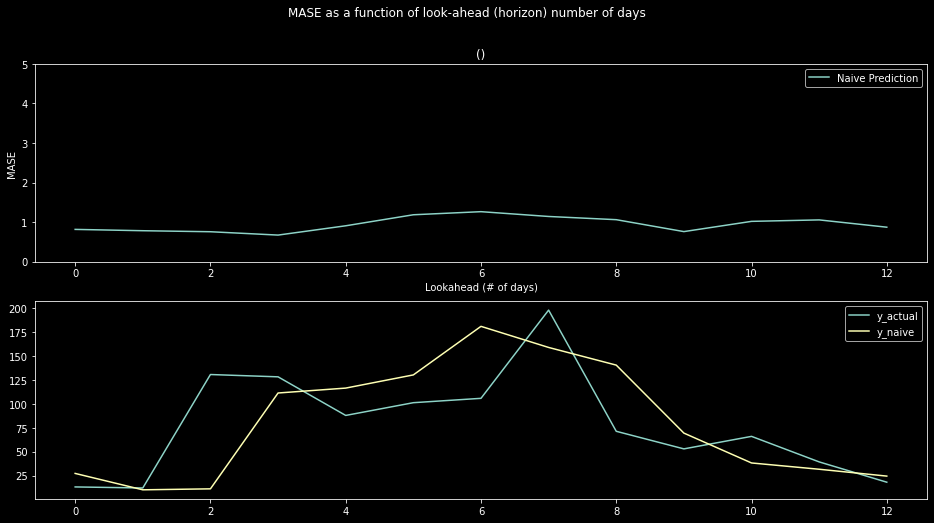

In [98]:
fig,ax_arr = plt.subplots(2,1,figsize=(16,8))
ax = ax_arr[0]
#ax.plot(prophet_accuracy, label = 'Prophet')
ax.plot(naive_accuracy, label = 'Naive Prediction')
ax.set_ylim([0,5])
#ax.set_yscale('log')
fig.suptitle("MASE as a function of look-ahead (horizon) number of days")
ax.set_title("()")
ax.set_xlabel("Lookahead (# of days)")
ax.legend()
ax.set_ylabel('MASE')
to_plot = ['y_actual','y_naive']
#to_plot = ['y_actual', 'y_naive', 'y_prophet']
look_ahead_idx = 7
[
    ax_arr[1].plot(
        forecasts[p][:,look_ahead_idx], label = p
    ) for p in to_plot
]
ax_arr[1].legend()

fig.savefig(
    os.path.join(
        data_path, 
        'power', 
        f'{signal_to_forecast}_forecast_{look_ahead_idx}_day_lookahead.png'
    )
)

# 11. Prediction - Power<a class="anchor" id="chapter11"></a>

Model the seasonally adjusted power series with an AR(n) model, evaluate forecast accuracy.

Make and use some of the standard measures for performance evaluation. 

The following tasks are suggested:
- plot the residual time series for consumption, wind and solar. 
- 
- use the mae, rmse, mape, and mase metrics to evaluate the performance of the linear trend model (yearly temperature)

In [99]:
input_filepath = os.path.join(
    data_path, 'power', 'power_decomposition_df.pickle'
)
# asfreq dataframe
df = pd.read_pickle(input_filepath)
df.columns

Index(['Consumption', 'Wind', 'Solar', 'Wind + Solar', 'month', 'year',
       'weekday', 'r_Consumption', 'Consumption_model_r', 'r_Wind',
       'Wind_model_r', 'r_Solar', 'Solar_model_r', 'Consumption_model_t',
       't_Consumption', 'Wind_model_t', 't_Wind', 'Solar_model_t', 't_Solar',
       't_Consumption_model_m', 'm_t_Consumption', 't_Wind_model_m',
       'm_t_Wind', 't_Solar_model_m', 'm_t_Solar', 'm_t_Consumption_model_d',
       'd_m_t_Consumption', 'pred_Consumption', 'res_Consumption', 'pred_Wind',
       'res_Wind', 'pred_Solar', 'res_Solar'],
      dtype='object')

In [108]:
df

,Consumption,Wind,Solar,Wind + Solar,month,year,weekday,r_Consumption,Consumption_model_r,r_Wind,Wind_model_r,r_Solar,Solar_model_r,Consumption_model_t,t_Consumption,Wind_model_t,t_Wind,Solar_model_t,t_Solar,t_Consumption_model_m,m_t_Consumption,t_Wind_model_m,m_t_Wind,t_Solar_model_m,m_t_Solar,m_t_Consumption_model_d,d_m_t_Consumption,pred_Consumption,res_Consumption,pred_Wind,res_Wind,pred_Solar,res_Solar
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-07-02,1305.601,29.880,85.774,115.654,7,2012,Monday,1283.908564,21.692436,125.027951,-95.147951,76.385603,9.388397,1324.048282,-18.447282,104.332770,-74.452770,87.256316,-1.482316,-70.737764,52.290481,-24.922724,-49.530046,52.212373,-53.694689,61.527912,-9.237431,1314.838431,-9.237431,79.410046,-49.530046,139.468689,-53.694689
2012-07-03,1351.059,13.989,93.205,107.194,7,2012,Tuesday,1282.914945,68.144055,125.178940,-111.189940,76.406545,16.798455,1324.192611,26.866389,104.627516,-90.638516,87.261726,5.943274,-70.737764,97.604153,-24.922724,-65.715792,52.212373,-46.269099,96.641973,0.962180,1350.096820,0.962180,79.704792,-65.715792,139.474099,-46.269099
2012-07-04,1357.488,32.237,144.079,176.316,7,2012,Wednesday,1282.436668,75.051332,124.497841,-92.260841,76.410192,67.668808,1324.336939,33.151061,104.922261,-72.685261,87.267136,56.811864,-70.737764,103.888825,-24.922724,-47.762538,52.212373,4.599491,95.384743,8.504082,1348.983918,8.504082,79.999538,-47.762538,139.479509,4.599491
2012-07-05,1358.012,60.654,128.246,188.900,7,2012,Thursday,1282.032364,75.979636,124.189181,-63.535181,76.386567,51.859433,1324.481267,33.530733,105.217007,-44.563007,87.272546,40.973454,-70.737764,104.268496,-24.922724,-19.640283,52.212373,-11.238919,76.707352,27.561145,1330.450855,27.561145,80.294283,-19.640283,139.484919,-11.238919
2012-07-06,1320.339,37.260,113.291,150.551,7,2012,Friday,1281.545499,38.793501,123.692173,-86.432173,76.386307,36.904693,1324.625596,-4.286596,105.511753,-68.251753,87.277956,26.013044,-70.737764,66.451168,-24.922724,-43.329029,52.212373,-26.199329,49.242610,17.208558,1303.130442,17.208558,80.589029,-43.329029,139.490329,-26.199329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-28,1431.500,254.201,142.157,396.358,6,2017,Wednesday,1383.323956,48.176044,276.907532,-22.706532,98.511414,43.645586,1481.654818,-50.154818,426.195126,-171.994126,93.164086,48.992914,-48.398638,-1.756179,-71.251296,-100.742830,62.619750,-13.626836,95.384743,-97.140922,1528.640922,-97.140922,354.943830,-100.742830,155.783836,-13.626836
2017-06-29,1411.060,193.698,105.583,299.281,6,2017,Thursday,1383.337608,27.722392,277.705981,-84.007981,98.496926,7.086074,1481.799146,-70.739146,426.489872,-232.791872,93.169496,12.413504,-48.398638,-22.340508,-71.251296,-161.540575,62.619750,-50.206246,76.707352,-99.047859,1510.107859,-99.047859,355.238575,-161.540575,155.789246,-50.206246
2017-06-30,1383.979,379.310,150.374,529.684,6,2017,Friday,1383.335391,0.643609,278.847293,100.462707,98.461156,51.912844,1481.943474,-97.964474,426.784617,-47.474617,93.174906,57.199094,-48.398638,-49.565836,-71.251296,23.776679,62.619750,-5.420656,49.242610,-98.808446,1482.787446,-98.808446,355.533321,23.776679,155.794656,-5.420656


In [101]:
# proportion of null entries per column

(df.isna().sum()/len(df)).sort_values(ascending=False)

Consumption                0.0
Solar_model_t              0.0
pred_Solar                 0.0
res_Wind                   0.0
pred_Wind                  0.0
res_Consumption            0.0
pred_Consumption           0.0
d_m_t_Consumption          0.0
m_t_Consumption_model_d    0.0
m_t_Solar                  0.0
t_Solar_model_m            0.0
m_t_Wind                   0.0
t_Wind_model_m             0.0
m_t_Consumption            0.0
t_Consumption_model_m      0.0
t_Solar                    0.0
t_Wind                     0.0
Wind                       0.0
Wind_model_t               0.0
t_Consumption              0.0
Consumption_model_t        0.0
Solar_model_r              0.0
r_Solar                    0.0
Wind_model_r               0.0
r_Wind                     0.0
Consumption_model_r        0.0
r_Consumption              0.0
weekday                    0.0
year                       0.0
month                      0.0
Wind + Solar               0.0
Solar                      0.0
res_Sola

<AxesSubplot:xlabel='Date'>

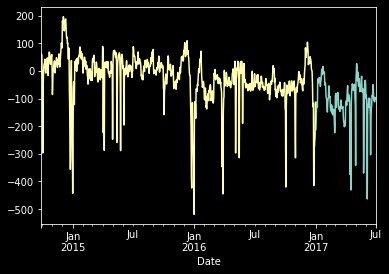

In [111]:
y_train_c = df.loc['2013':'2016', 'res_Consumption']
df.loc['2017':, 'res_Consumption'].plot()
y_train_c.plot()

In [112]:
# create an ARMA model for our 2013 - 2016 consumption residual data

my_estimator = AutoReg(y_train_c, 2, 'c')
my_estimator_results =  my_estimator.fit()
my_estimator_results.summary()

C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:        res_Consumption   No. Observations:                  825
Model:                     AutoReg(2)   Log Likelihood               -4455.926
Method:               Conditional MLE   S.D. of innovations             54.343
Date:                Sat, 04 Jun 2022   AIC                           8919.851
Time:                        20:51:14   BIC                           8938.703
Sample:                    10-01-2014   HQIC                          8927.084
                         - 12-31-2016                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -5.0378      1.963     -2.567      0.010      -8.884      -1.191
res_Consumption.L1     0.6958      0.035     20.002      0.000       0.628       0.764
res_Consumption.L2     0.0775      0.035      2.220      0.026       0.009       0.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2603           +0.0000j            1.2603            0.0000
AR.2          -10.2402           +0.0000j           10.2402            0.5000
-----------------------------------------------------------------------------
"""

C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Date
2014-09-29     60.039409
2014-09-30     57.578019
2014-10-01     -5.979172
2014-10-02    -19.021109
2014-10-03   -297.161696
Name: res_Consumption, dtype: float64

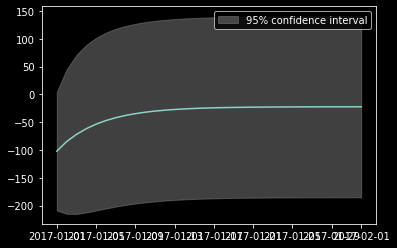

In [115]:
# predict the residual for the first month of 2017 (out of sample)

start = '2017-01-01'
finish = '2017-02-01'

y_pred = my_estimator_results.predict(start, finish)
my_estimator_results.plot_predict(start=start, end=finish)

y_train_c.head()

In [116]:
sel = ar_select_order(y_train_c, 13, 'bic', glob=True)
res = sel.model.fit()
print(res.summary())

C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                            AutoReg Model Results                             
Dep. Variable:        res_Consumption   No. Observations:                  825
Model:             Restr. AutoReg(12)   Log Likelihood               -4367.043
Method:               Conditional MLE   S.D. of innovations             52.069
Date:                Sat, 04 Jun 2022   AIC                           8746.085
Time:                        20:57:36   BIC                           8774.290
Sample:                    10-11-2014   HQIC                          8756.912
                         - 12-31-2016                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.1756      1.923     -2.171      0.030      -7.945      -0.406
res_Consumption.L1      0.6629      0.028     23.443      0.000       0.607       0.718
res_Consumption.

C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Use prior measures on the forecasts<a class="anchor" id="section_11_1"></a>

We will do the following:
- evaluate a one-step ahead regime
- evaluate a ten-step ahead regime
- evaluate n steps ahead

Using the metrics:

- MAE
- RMSE
- MAPE
- MASE

In [117]:
def predict_from_ar(training_df, test_df, col_name, seasonal_dummies=False):
    y_series = training_df[col_name]
    n = y_series.shape[0]

    model = AutoReg(y_series, 12, 'c', seasonal = seasonal_dummies)
    fitted_model =  model.fit()
    y_pred = fitted_model.predict(test_df.index[0], test_df.index[-1])
    
    test_df = pd.concat([test_df, pd.Series(name='pred', index=test_df.index, dtype=float)], axis=1)
    test_df = pd.concat([test_df, pd.Series(name='naive', index=test_df.index, dtype=float)], axis=1)

    test_df.loc[:, 'pred'] = y_pred
    test_df.loc[:, 'naive'] = training_df[col_name].iloc[-1]

    return test_df

In [118]:
print(f'from {df.index[0]} to {df.index[-1]}')

def evaluate(df, col_name, lookahead, seasonal_dummies=False):

    #start_years = [2010, 2011, 2012]
    training_duration = pd.Timedelta(weeks=104)
    training_start = pd.Timestamp('2014-01-01')
    training_end = training_start + training_duration
    test_end = training_end + lookahead

    stride = pd.Timedelta(weeks=3)
    training_starts=[]
    training_ends=[]
    test_ends=[]
    
    while test_end < df.index[-1]:
        training_starts.append(training_start)
        training_ends.append(training_end)
        test_ends.append(test_end)
        training_start += stride
        training_end += stride
        test_end += stride
#        print('training_start:',training_start)
#        print('training_end:',training_end)
#        print('test_end:',test_end)
    
    actual = pd.Series(np.zeros((len(training_starts))))
    pred = pd.Series(np.zeros((len(training_starts))))
    naive = pd.Series(np.zeros((len(training_starts))))
    fig, ax = plt.subplots(figsize=(20,10))
    df.loc[training_start:, col_name].plot(ax=ax, legend=False)
    
    for i, (
        training_start, training_end, test_end
    ) in enumerate(zip(training_starts,training_ends,test_ends)):
        
        training_df = df.loc[training_start:training_end,:]
        test_df = df.loc[training_end:test_end,:]
            
        test_df = predict_from_ar(
            training_df, test_df, col_name, seasonal_dummies
        )
        
#        print(test_df.head())

        test_df[['pred', 'naive']].plot(ax=ax, legend=False)
        actual[i] = test_df[col_name].iloc[-1]
        pred[i] = test_df['pred'].iloc[-1]
        naive[i] = test_df['naive'].iloc[-1]
        
#    print('actual', actual)
#    print('pred', pred)
    mae = get_mae(actual, pred)
    rmse = get_rmse(actual, pred)
    mape = get_mape(actual, pred)
    benchmark_mae = get_mae(actual, naive)
    mase = get_mase(actual, pred, benchmark_mae)
    print(f'mae is {mae}\nrmse is {rmse}\nmape is {mape}\nmase is {mase}')

from 2012-07-02 00:00:00 to 2017-07-02 00:00:00


C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\deterministic.py:435: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_i

C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\deterministic.py:435: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be use

C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\deterministic.py:435: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
C:\Users\Dell5520\PycharmProjects\personal\machine_learning\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be use

mae is 49.1185
rmse is 65.1273
mape is 3.2587
mase is 1.1385


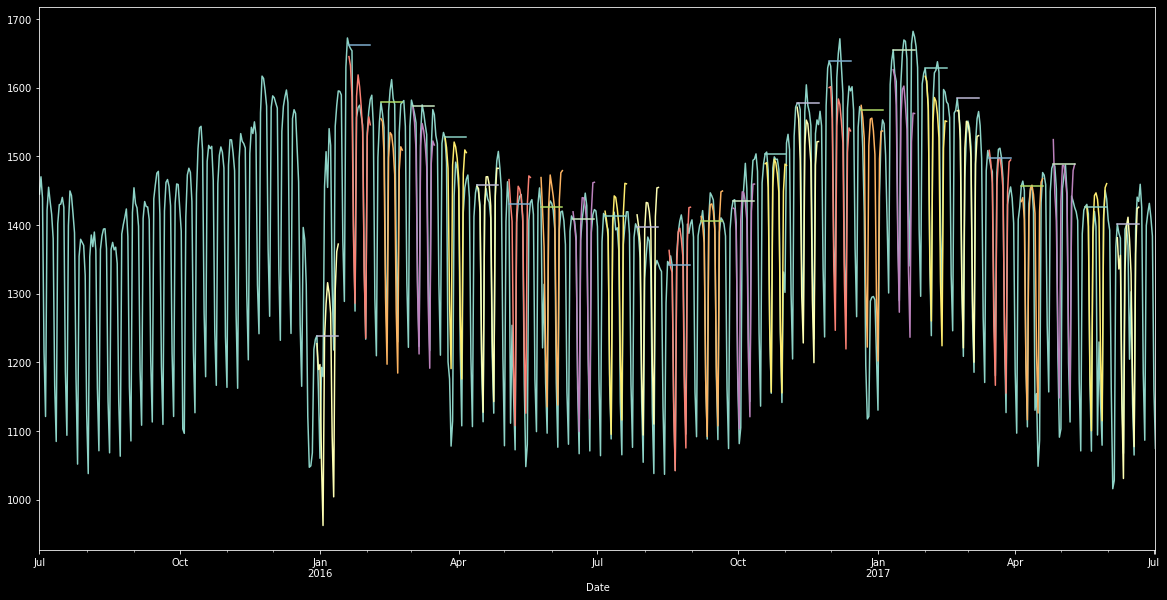

In [119]:
#evaluate(df, 'res_Consumption', pd.Timedelta(weeks=2))
evaluate(df, 'Consumption', pd.Timedelta(weeks=2), seasonal_dummies=True)